# Проект "Прогнозирование стоимости автомобиля по характеристикам"

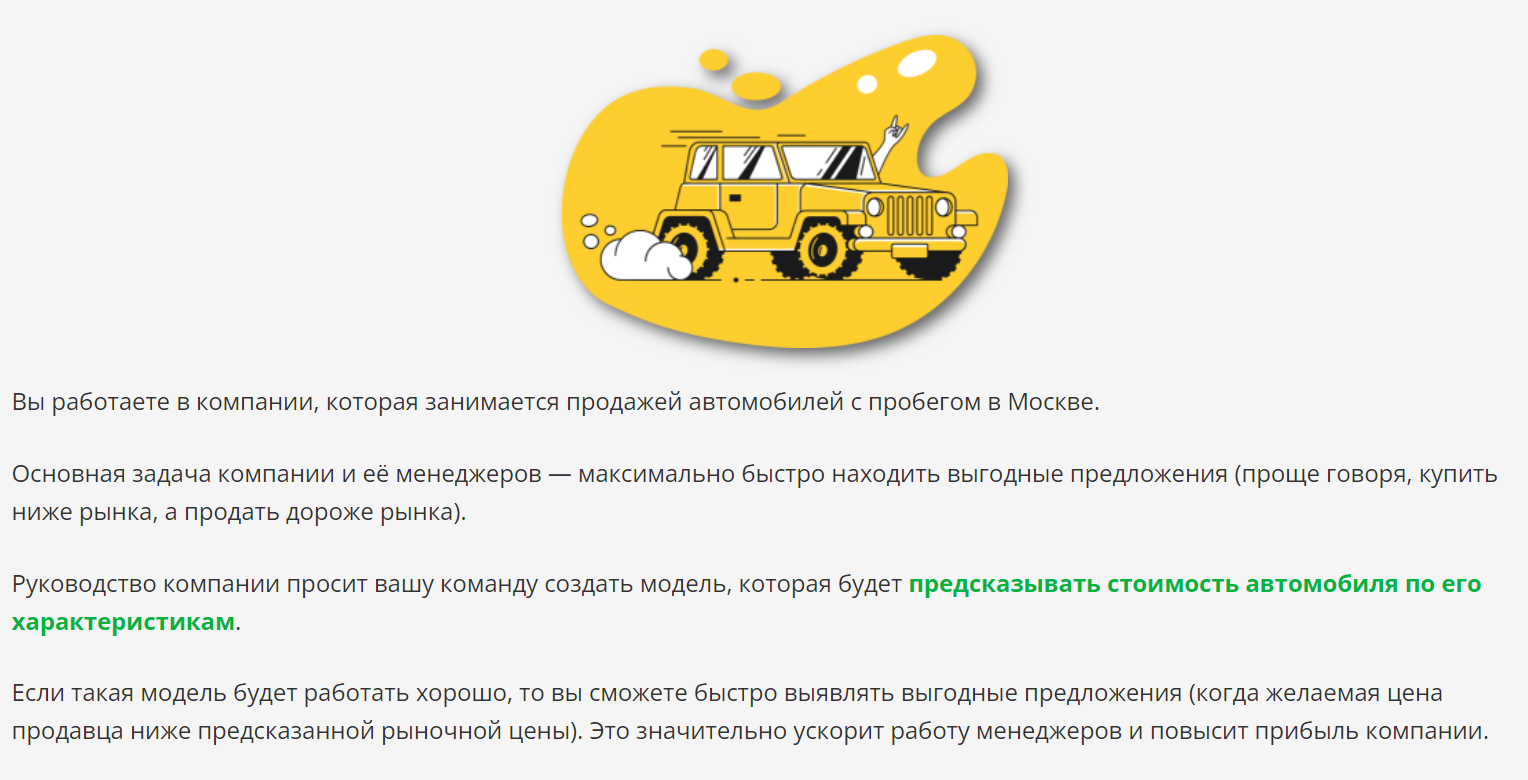

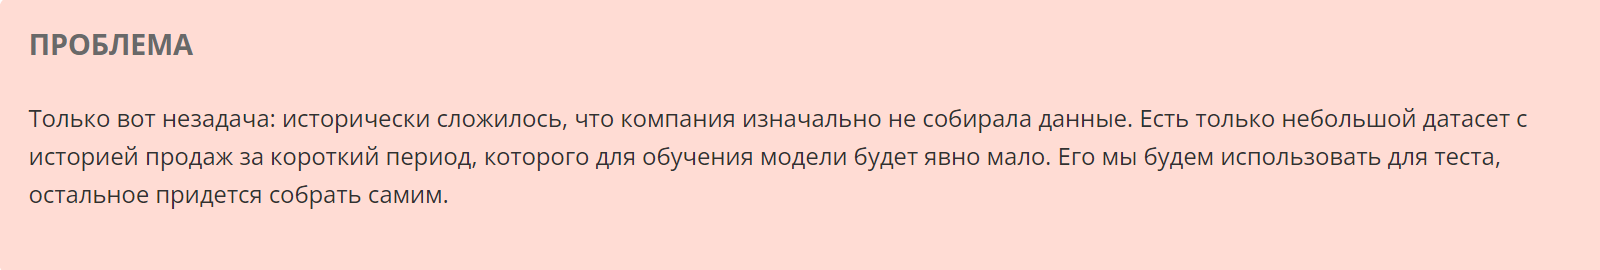

# Библиотеки

In [185]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import sys
import re
import seaborn as sns
from math import log
import matplotlib.pyplot as plt
import sys
from pandas import Series


# from sklearn.utils import deprecated
# import sklearn
# estimators = sklearn.utils.all_estimators(type_filter=None)
# for name, class_ in estimators:
#    if hasattr(class_, 'predict_proba'):
#        print(name)

from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import recall_score
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

#from catboost import CatBoostRegressor


#!pip install featuretools

# import warnings filter
#from warnings import simplefilter
# ignore all future warnings
#simplefilter(action='ignore', category=FutureWarning)

#!pip install scikit-learn
#!pip install ipywidgets
#from sklearn.utils import all_estimators

#from sklearn.utils import shuffle

#!pip install catboost

#!pip install lazypredict
#import lazypredict
#!pip uninstall scikit-learn -y
#!pip install scikit-learn==0.24
#from lazypredict.Supervised import LazyRegressor


In [186]:
# всегда фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42
mape = mean_absolute_percentage_error

# функции

In [187]:
# функция для перевода test.enginePower  в числа:
def enginePower_int(x):
    x = str(x).split(' ')[0]
    return float(x)

In [188]:
#Функция для сравнения типов данных в датасетах
def column_format(a,b):
    common_columns = set(a.columns).intersection(b.columns)

    index_list = b[common_columns].dtypes.index.to_list()
    test_list = b[common_columns].dtypes.values.tolist()
    train_list = a[common_columns].dtypes.values.tolist()
    example_test = b[common_columns].values.tolist()[2]
    example_train = a[common_columns].values.tolist()[2]

    dict_comparison = {'title': index_list, 'test_type': test_list, 'train_type': train_list,'example_test': example_test,'example_train': example_train}

    comparison = pd.DataFrame(dict_comparison)
    display(comparison.sort_values('title'))

In [189]:
#Функция для получения численных данных об объеме двигателя
def engineDisplacement_to_float(row:str):
    extracted_value = re.findall('\d\.\d', str(row))
    if extracted_value:
        return float(extracted_value[0])
    return None

# подгружаем данные

In [190]:
# VERSION    = 16
# DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключение к ноутбуку внешнего датасета
# DIR_TEST   = '../input/sf-dst-car-price-prediction/'
#VAL_SIZE   = 0.20   # 20%

In [191]:
from google.colab import drive
drive.mount('/content/drive')
path = './drive/My Drive/Colab Notebooks/skillfactory/module_6/project_5'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [192]:
train_df = pd.read_csv(path+'/all_auto_ru_09_09_2020.csv') # датасет для обучения модели

test_df = pd.read_csv(path+'/test_avto_kaggle.csv')

sample_submission = pd.read_csv(path + '/sample_submission_kaggle.csv')

In [193]:
train = train_df. copy()
test = test_df.copy()

Использую существующий датасет для обучения модели

# Первичный осмотр данных

In [194]:
# показывать dataframe без ограничения количества столбцов и 100 строк по умолчанию
pd.options.display.max_rows = 100
pd.options.display.max_columns = None

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.13 (default, Apr 24 2022, 01:04:09) 
Numpy        : 1.21.6


##  Информация по Sample_submission

In [195]:
sample_submission.head(2)

,sell_id,price
0,1100575026,0
1,1100549428,0


In [196]:
# посмотрим на размеры датасета
sample_submission.shape

(34686, 2)

##  Информация по обучающему датасету 

In [197]:
train

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,2.3,136.0,ПТС Оригинал!\nПолный комплект ключей!\nПо рез...,230000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,NaN,240000,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,101.0,"Машина не гнилая, дыр нет, днище целое, даже в...",300000,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89373,Минивэн,SSANG_YONG,040001,дизель,2004.0,2.7d AT (163 л.с.) 4WD,5.0,2006,MINIVAN AUTOMATIC 2.7d,AUTOMATIC,2.7d,163.0,СВЕТИТ КРУТИТ РАБОТАЕТ ВСЁ. БЕЗ ТОРГА .В МОСК...,260000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,450000.0,2020-02-11T09:29:59Z,NaN,RODIUS
89374,Минивэн,SSANG_YONG,CACECB,дизель,2004.0,2.7d AT (163 л.с.) 4WD,5.0,2007,MINIVAN AUTOMATIC 2.7d,AUTOMATIC,2.7d,163.0,"Автомобиль на ходу, каждый день в движении.\nС...",300000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2017, 'month': 2}",485000.0,2020-05-30T18:56:30Z,NaN,RODIUS
89375,Минивэн,SSANG_YONG,040001,дизель,2013.0,2.0d AT (149 л.с.) 4WD,5.0,2014,MINIVAN AUTOMATIC 2.0d,AUTOMATIC,2.0d,149.0,"Автомобиль куплен в декабре 2015 г., новым. Вс...",126000,"{'id': '10408082', 'name': 'Luxury', 'availabl...",полный,LEFT,NaN,1.0,ORIGINAL,True,"{'year': 2015, 'month': 12}",1090000.0,2020-08-30T14:39:15Z,NaN,STAVIC
89376,Минивэн,SSANG_YONG,97948F,дизель,2013.0,2.0d AT (149 л.с.) 4WD,5.0,2013,MINIVAN AUTOMATIC 2.0d,AUTOMATIC,2.0d,149.0,Продаю семейного любимца. Большой вместительны...,84000,"{'id': '10408081', 'name': 'Elegance', 'availa...",полный,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2017, 'month': 10}",1180000.0,2019-05-14T15:43:20Z,NaN,STAVIC


In [198]:
# посмотрим на размеры датасета
train.shape

(89378, 26)

In [199]:
# количество пропущенных значений
train.isnull().sum()

bodyType                    1
brand                       0
color                       0
fuelType                    0
modelDate                   1
name                        1
numberOfDoors               1
productionDate              0
vehicleConfiguration        1
vehicleTransmission         1
engineDisplacement          1
enginePower                 1
description              3254
mileage                     0
Комплектация                0
Привод                      1
Руль                        0
Состояние               89378
Владельцы               13588
ПТС                       361
Таможня                     0
Владение                60177
price                     410
start_date                  0
hidden                  89378
model                       0
dtype: int64

In [200]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [201]:
train.describe()

,modelDate,numberOfDoors,productionDate,enginePower,mileage,Состояние,Владельцы,price,hidden
count,89377.000000,89377.000000,89378.000000,89377.000000,89378.000000,0.0,75790.000000,8.896800e+04,0.0
mean,2008.543294,4.510467,2010.832531,171.231637,134828.811497,NaN,2.233698,1.294586e+06,NaN
std,7.415436,0.653203,7.024776,83.527540,102979.784485,NaN,0.817455,1.950410e+06,NaN
min,1904.000000,0.000000,1904.000000,11.000000,0.000000,NaN,1.000000,1.600000e+04,NaN
25%,2005.000000,4.000000,2007.000000,115.000000,56042.500000,NaN,2.000000,3.500000e+05,NaN
50%,2009.000000,5.000000,2011.000000,150.000000,130000.000000,NaN,2.000000,6.500000e+05,NaN
75%,2014.000000,5.000000,2016.000000,199.000000,194939.750000,NaN,3.000000,1.480000e+06,NaN
max,2020.000000,5.000000,2020.000000,800.000000,1000000.000000,NaN,3.000000,9.900000e+07,NaN


In [202]:
train.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
       'hidden', 'model'],
      dtype='object')

In [203]:
# Найдем количество уникальных значений в столбцах (строковых признаках) датасета
object_columns = [c for c in train.columns if train[c].dtypes == 'object']
for column in object_columns:
    unique = train[column].unique()
    if len(unique)>20:       #  здесь всё перечислять не нужно, слишком много!
       print('Количество уникальных значений для столбца',column, '-', len(unique),end='\n')
    else :  # укажу только количество уникальных значений.
       print('Количество уникальных значений для столбца',column, '-', len(unique),unique,end='\n')
      

Количество уникальных значений для столбца bodyType - 169
Количество уникальных значений для столбца brand - 36
Количество уникальных значений для столбца color - 16 ['040001' 'EE1D19' '0000CC' 'CACECB' '007F00' 'FAFBFB' '97948F' '22A0F8'
 '660099' '200204' 'C49648' 'DEA522' '4A2197' 'FFD600' 'FF8649' 'FFC0CB']
Количество уникальных значений для столбца fuelType - 6 ['бензин' 'дизель' 'электро' 'гибрид' 'универсал' 'газ']
Количество уникальных значений для столбца name - 4485
Количество уникальных значений для столбца vehicleConfiguration - 1861
Количество уникальных значений для столбца vehicleTransmission - 5 ['MECHANICAL' 'AUTOMATIC' 'ROBOT' 'VARIATOR' nan]
Количество уникальных значений для столбца engineDisplacement - 535
Количество уникальных значений для столбца description - 77569
Количество уникальных значений для столбца Комплектация - 5839
Количество уникальных значений для столбца Привод - 4 ['полный' 'передний' 'задний' nan]
Количество уникальных значений для столбца Руль 

In [204]:
# Найдем количество уникальных значений в столбцах (float64 признаках) датасета
float64_columns = [c for c in train.columns if train[c].dtypes == 'float64']
for column in float64_columns:
    unique = train[column].unique()
    if column!='enginePower':       # доход клиента здесь весь перечислять не нужно!
       print('Количество уникальных значений для столбца',column, '-', len(unique), unique,end='\n')
    else :    # укажу только количество уникальных значений.
      print('Количество уникальных значений для столбца',column, '-', len(unique),end='\n')
      

Количество уникальных значений для столбца modelDate - 79 [1990. 1982. 1988. 1976. 1983. 1979. 1986. 1991. 1978. 1987. 1992. 1938.
 2010. 2014. 2000. 2016. 2004. 2012. 2008. 1996. 2003. 2015. 2011. 2007.
 1999. 1994. 2009. 2018. 2001. 1997. 2006. 2019. 2013. 2017. 2002. 2005.
 1980. 1984. 1998. 1966. 1975. 1937. 1936. 1949. 2020. 1995. 1981. 1972.
 1977. 1989. 1968. 1985. 1958. 1971. 1956. 1955. 1970. 1963. 1973. 1964.
 1957. 1993. 1960. 1927. 1908. 1932.   nan 1965. 1935. 1967. 1948. 1969.
 1934. 1974. 1950. 1961. 1904. 1959. 1951.]
Количество уникальных значений для столбца numberOfDoors - 6 [ 4.  5.  3.  2. nan  0.]
Количество уникальных значений для столбца enginePower - 397
Количество уникальных значений для столбца Состояние - 1 [nan]
Количество уникальных значений для столбца Владельцы - 4 [ 3.  1.  2. nan]
Количество уникальных значений для столбца price - 8169 [200000.  60000.  99000. ... 534900. 749750. 864000.]
Количество уникальных значений для столбца hidden - 1 [nan]


In [205]:
# Найдем количество уникальных значений в столбцах (bool признаках) датасета
bool_columns = [c for c in train.columns if train[c].dtypes == 'bool']
for column in bool_columns:
    unique = train[column].unique()
    print('Количество уникальных значений для столбца',column, '-', len(unique), unique)

Количество уникальных значений для столбца Таможня - 1 [ True]


In [206]:
# Найдем количество уникальных значений в столбцах (int64 признаках) датасета
int64_columns = [c for c in train.columns if train[c].dtypes == 'int64']
for column in int64_columns:
    unique = train[column].unique()
    print('Количество уникальных значений для столбца',column, '-', len(unique), unique)
    print('минимальное значение признака',column,'-',unique.min(),'; максимальное значение признака',column,'-',unique.max(),end='\n')

Количество уникальных значений для столбца productionDate - 80 [1991 1986 1989 1993 1992 1994 1987 1988 1985 1983 1980 1984 1990 1981
 1995 1938 2014 2011 2013 2012 2016 2015 2010 2002 2000 2001 2020 2008
 2018 2019 2007 2003 2017 2006 2005 2004 2009 1997 1999 1998 1996 1982
 1972 1978 1937 1949 1948 1950 1953 1975 1969 1959 1974 1961 1955 1976
 1964 1971 1967 1957 1931 1927 1923 1924 1979 1970 1932 1939 1977 1951
 1973 1954 1960 1968 1904 1966 1965 1963 1936 1952]
минимальное значение признака productionDate - 1904 ; максимальное значение признака productionDate - 2020
Количество уникальных значений для столбца mileage - 17403 [350000 173424 230000 ... 262800 106124 191768]
минимальное значение признака mileage - 0 ; максимальное значение признака mileage - 1000000


**Обучающий Датасет train содержит:**

* 89378 строк.

* 26 признаков:  bool(1), float64(7), int64(2), object(16).

* Пропуски в признаках: 

     1.   description (3254)
     2.   Привод  (1)
     3.   Состояние (89378)
     4.   Владельцы (13588)
     5.   ПТС (361)
     6.   Владение  (60177)
     7.   price   (410)
     8.   hidden  (89378)

  т.е 2 признака "пустые" полностью


* Целевая переменная price 

## Информация по тестовому датасету 

In [207]:
test.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [208]:
# посмотрим на размеры датасета
test.shape

(34686, 32)

In [209]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [210]:
# количество пропущенных значений
test.isnull().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

In [211]:
test.describe()

,mileage,modelDate,numberOfDoors,parsing_unixtime,productionDate,sell_id
count,34686.000000,34686.000000,34686.000000,3.468600e+04,34686.000000,3.468600e+04
mean,162009.767889,2007.074728,4.450816,1.603287e+09,2009.264602,1.098300e+09
std,100676.559489,7.415894,0.703040,1.493071e+05,7.047661,1.911225e+07
min,1.000000,1904.000000,0.000000,1.603107e+09,1904.000000,2.665000e+03
25%,91153.500000,2004.000000,4.000000,1.603221e+09,2006.000000,1.099049e+09
50%,149779.500000,2008.000000,5.000000,1.603254e+09,2011.000000,1.100911e+09
75%,215000.000000,2012.000000,5.000000,1.603290e+09,2014.000000,1.101245e+09
max,1000000.000000,2020.000000,5.000000,1.603710e+09,2020.000000,1.101375e+09


In [212]:
# Найдем количество уникальных значений в столбцах (int64 признаках) датасета
int64_columns_test = [c for c in test.columns if test[c].dtypes == 'int64']
for column in int64_columns_test:
    unique = test[column].unique()
    print('Количество уникальных значений для столбца',column, '-', len(unique), unique)
    print('минимальное значение признака',column,'-',unique.min(),'; максимальное значение признака',column,'-',unique.max(),end='\n')

Количество уникальных значений для столбца mileage - 11268 [ 74000  60563  88000 ... 121276 212678 157965]
минимальное значение признака mileage - 1 ; максимальное значение признака mileage - 1000000
Количество уникальных значений для столбца modelDate - 66 [2013 2017 2008 2009 2016 2012 2015 2010 2006 2000 2007 1994 2004 1999
 2005 1976 2001 1969 1996 1998 1989 1934 2014 2011 2018 1986 1997 1990
 2019 2002 1991 1987 1980 1982 1938 1988 2003 1983 1978 1979 1984 1992
 1995 1993 1985 1974 1966 1977 1981 1972 1968 1975 1949 1937 1936 1973
 1959 1958 2020 1965 1971 1904 1963 1955 1951 1960]
минимальное значение признака modelDate - 1904 ; максимальное значение признака modelDate - 2020
Количество уникальных значений для столбца numberOfDoors - 5 [5 4 2 3 0]
минимальное значение признака numberOfDoors - 0 ; максимальное значение признака numberOfDoors - 5
Количество уникальных значений для столбца parsing_unixtime - 34686 [1603226273 1603226277 1603226280 ... 1603707843 1603707909 160371026

In [213]:
# Найдем количество уникальных значений в столбцах (строковых признаках) датасета
object_columns_test = [c for c in test.columns if test[c].dtypes == 'object']
for column in object_columns_test:
    unique = test[column].unique()
    if len(unique)>20:       #  здесь всё перечислять не нужно, слишком много!
       print('Количество уникальных значений для столбца',column, '-', len(unique),end='\n')
    else :  # укажу только количество уникальных значений.
       print('Количество уникальных значений для столбца',column, '-', len(unique),unique,end='\n')

Количество уникальных значений для столбца bodyType - 24
Количество уникальных значений для столбца brand - 12 ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']
Количество уникальных значений для столбца car_url - 34686
Количество уникальных значений для столбца color - 16 ['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный' 'жёлтый' 'голубой' 'оранжевый'
 'фиолетовый' 'золотистый' 'розовый']
Количество уникальных значений для столбца complectation_dict - 2365
Количество уникальных значений для столбца description - 31732
Количество уникальных значений для столбца engineDisplacement - 55
Количество уникальных значений для столбца enginePower - 315
Количество уникальных значений для столбца equipment_dict - 23706
Количество уникальных значений для столбца fuelType - 5 ['бензин' 'дизель' 'гибрид' 'электро' 'газ']
Количество уникальных значений для столбца image - 34557
Колич

## краткая информация датасетов

**Обучающий Датасет train содержит:**

* 89378 строк.

* 26 признаков:  bool(1), float64(7), int64(2), object(16).

* Пропуски в признаках: 

     1.   description (3254)
     2.   Привод  (1)
     3.   Состояние (89378)
     4.   Владельцы (13588)
     5.   ПТС (361)
     6.   Владение  (60177)
     7.   price   (410)
     8.   hidden  (89378)

  т.е 2 признака "пустые" полностью


* Целевая переменная price 

**Тестовый Датасет train содержит:**

* 34686 строк.

* 32 признаков:  int64(6), object(26).

* Пропуски в признаках: 

     1.   complectation_dict      28268
     2.   equipment_dict           9996
     3.   Владение                22691
     4.   ПТС                         1

Видим в обучающем и тестовом датасетах есть различия. В обучающем датасете нет некоторых данных, которые есть в тестовом. 

В обоих датасетах есть пропуски. В обучающем датасете в двух колонках состояние и hidden отсутствуют данные вообще.

## Краткое Описание признаков

* bodyType - тип кузова
* brand - марка авто
* car_url - ссылка на объявление
* color - цвет
* complectation_dict - комплектация
* description - описание и реклама
* engineDisplacement - объем двигателя
* enginePower - мощность двигателя
* equipment_dict - словарь установленного оборудования
* fuelType - тип топлива
* image - ссылка на картинку авто
* mileage - пробег
* modelDate - год модели
* model_info - словарь описания модели
* model_name - имя модели
* name - краткое описание двигателя и мощности
* numberOfDoors - количество дверей
* parsing_unixtime - время сбора данных
* priceCurrency - валюта, в которой указывалась цена
* productionDate - дата выпуска авто
* sell_id - идентифиактор объявления
* super_gen - описание характеристик авто
* vehicleConfiguration - краткое описание привода, кузова и объема двигателя
* vehicleTransmission - тип коробки передач
* vendor - регион производства авто
* Владельцы - количество владельцев
* Владение - срок владения
* ПТС - оригинал/дубликат
* Привод - привод)
* Руль - расположение рулевого колеса
* Состояние - состояние авто на момент подачи объявления
* Таможня - авто растаможено в РФ или нет
* Комплектация - словарь с описанием комплектации
* start_date - дата подачи объявления
* hidden - пустой признак в тренировочном датасете

# ***EDA***

### Работа с пропусками

In [214]:
# Удалим строки в которых отсутствуют данные в признаке "цена", т.к это целевой признак и в их немного
train.dropna(subset=['price'], inplace=True)
# В признаке "Привод" пропущенно только одно значение, легче удалить строку с пропуском
train.dropna(subset=['Привод'], inplace=True)
# Есть 2 признака (Состояние и hidden) полностью пустых, их мы удалим из датасета
train = train.drop(['Состояние'], axis=1)
train = train.drop(['hidden'], axis=1)


In [215]:
# В признаке ПТС в тестовом датасете пропущенно только одно значение, легче удалить строку с пропуском
test.dropna(subset=['ПТС'], inplace=True)
# ну и в обучающем датасете в признаке ПТС  пропусков не много (361 из 89378), адалим их и здесь
train.dropna(subset=['ПТС'], inplace=True)
# "Владение" (срок владения последним хозяином) - очень много пропусков в обучающем датасете и в тестовом.
#  так как у нас есть еще информация о дате производства , то признак " ВЛАДЕНИЕ" можно удалить это будет не критично
train = train.drop(['Владение'], axis=1)
test = test.drop(['Владение'], axis=1)

In [216]:
test.isnull().sum(), train.isnull().sum()

(bodyType                    0
 brand                       0
 car_url                     0
 color                       0
 complectation_dict      28267
 description                 0
 engineDisplacement          0
 enginePower                 0
 equipment_dict           9995
 fuelType                    0
 image                       0
 mileage                     0
 modelDate                   0
 model_info                  0
 model_name                  0
 name                        0
 numberOfDoors               0
 parsing_unixtime            0
 priceCurrency               0
 productionDate              0
 sell_id                     0
 super_gen                   0
 vehicleConfiguration        0
 vehicleTransmission         0
 vendor                      0
 Владельцы                   0
 ПТС                         0
 Привод                      0
 Руль                        0
 Состояние                   0
 Таможня                     0
 dtype: int64, bodyType                

Пропуски остались 

в train: 

*   description (описание и реклама)    3233        
*   Владельцы   (кол-во владельцев)    13208

в test: 

*   complectation_dict    (комплектация)                     28267
*   equipment_dict (словарь установленного оборудования)   9995

с ними надо проводить дополнительный анализ. 

### Приведем к одинаковым видам признаки в  train и test

In [217]:
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которые есть только в test:",len(dif_list), dif_list)
dif_list = list(set(train.columns).difference(test.columns))
print("Список колонок, которые есть только в train:",len(dif_list), dif_list)

Список колонок, которые есть только в test: 12 ['parsing_unixtime', 'super_gen', 'priceCurrency', 'equipment_dict', 'model_name', 'model_info', 'vendor', 'sell_id', 'image', 'complectation_dict', 'car_url', 'Состояние']
Список колонок, которые есть только в train: 4 ['price', 'start_date', 'model', 'Комплектация']


в тестовом датасете есть 12 признаков которых нет в обучающем, 

и 4 признака в обучающем, которых нет в тестовом

####***посмотрим вид и тип в одноименных столбцах датасетов***

In [218]:
column_format(train,test)

,title,test_type,train_type,example_test,example_train
18,bodyType,object,object,лифтбек,Универсал 5 дв.
16,brand,object,object,SKODA,AUDI
6,color,object,object,серый,0000CC
8,description,object,object,"Все автомобили, представленные в продаже, прох...",ПТС Оригинал!\nПолный комплект ключей!\nПо рез...
4,engineDisplacement,object,object,1.8 LTR,2.3
1,enginePower,object,float64,152 N12,136.0
3,fuelType,object,object,бензин,бензин
7,mileage,int64,int64,88000,230000
2,modelDate,int64,float64,2013,1988.0
5,name,object,object,DSG 1.8 AMT (152 л.с.),2.3 MT (136 л.с.) 4WD


In [219]:
# Сгенерируем список столбцов, которые есть и в train, и в test
cols_common = list(set(test.columns).intersection(train.columns))

# Посмотрим на данные в одноименных столбцах
# Проверим, в каких одноименных столбцах типы данных различаются

cols_types_dif = []  # список столбцов, у которых типы данных отличаются
print('Всего общих столбцов в test и train -', len(cols_common),':')
for col in cols_common:
    print(col)
    print("\tВ test -",test[col][2], 'кол-во уникальных значений', len(test[col].unique()))
    print("\tВ train -",train[col][2],'кол-во уникальных значений', len(train[col].unique()))
    if type(test[col][0]) != type(train[col][0]):
        print(f"\t: для train - {type(train[col][0])}, для test - {type(test[col][0])}")
        cols_types_dif.append(col)
    else:
        print("\t",type(test[col][0]))

Всего общих столбцов в test и train - 19 :
Таможня
	В test - Растаможен кол-во уникальных значений 1
	В train - True кол-во уникальных значений 1
	: для train - <class 'numpy.bool_'>, для test - <class 'str'>
enginePower
	В test - 152 N12 кол-во уникальных значений 315
	В train - 136.0 кол-во уникальных значений 391
	: для train - <class 'numpy.float64'>, для test - <class 'str'>
modelDate
	В test - 2013 кол-во уникальных значений 66
	В train - 1988.0 кол-во уникальных значений 78
	: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
fuelType
	В test - бензин кол-во уникальных значений 5
	В train - бензин кол-во уникальных значений 5
	 <class 'str'>
name
	В test - DSG 1.8 AMT (152 л.с.) кол-во уникальных значений 2780
	В train - 2.3 MT (136 л.с.) 4WD кол-во уникальных значений 4473
	 <class 'str'>
engineDisplacement
	В test - 1.8 LTR кол-во уникальных значений 55
	В train - 2.3 кол-во уникальных значений 533
	 <class 'str'>
description
	В test - Все автомобили, предс

####  **Признаки "model" и "model_name"** 

In [220]:
train['model'].unique()[:40]

array(['100', '200', '80', '90', '920', 'A1', 'A2', 'A3', 'A4',
       'A4_ALLROAD', 'A5', 'A6', 'ALLROAD', 'A7', 'A8', 'COUPE', 'E_TRON',
       'Q3', 'Q3_SPORTBACK', 'Q5', 'Q7', 'Q8', 'R8', 'RS3', 'RS4', 'RS5',
       'RS6', 'RS7', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'SQ5', 'TT',
       'TT_RS', 'TTS', 'V8', '02'], dtype=object)

In [221]:
test['model_name'].unique()[:40]

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', 'YETI', 'KODIAQ', 'RAPID',
       'FABIA', 'ROOMSTER', 'FELICIA', 'KAROQ', 'FABIA_RS', '120',
       '100_SERIES', 'FAVORIT', 'POPULAR', 'Q5', 'R8', 'Q7', 'Q3', 'A4',
       'A3', 'A5', 'A6', 'RS7', 'S6', 'RS6', 'ALLROAD', 'TT', 'S5', 'S8',
       'A1', 'A8', '80', 'A7', 'RSQ3', 'RS3', 'A4_ALLROAD', 'Q8', '100',
       'SQ5'], dtype=object)

In [222]:
#Признак наименования модели в обучающем и тестовом датасэте имеет разные названия: model - в обучающем, model_name - в тестовом. 
#Переименнуем все как в тестовом.

train = train.rename(columns = {"model": "model_name"})

####***Признак Состояние***

In [223]:
# признак Состояние в тестовом датасете имеет одно значение, не несет информации для задачи, удалим
test = test.drop(['Состояние'], axis=1)

####***Признаки 'Комплектация' и 'complectation_dict'***

In [224]:
train['Комплектация'].unique()[:2], test['complectation_dict'].unique()[:2]

(array(["{'id': '0'}",
        "{'id': '20717199', 'name': 'Basis', 'available_options': ['sport-seats', 'multi-wheel', 'heated-wash-system', 'airbag-passenger', 'lock', 'door-sill-panel', 'electro-mirrors', 'mirrors-heat', 'start-stop-function', 'computer', 'seat-transformation', 'wheel-power', 'fabric-seats', 'airbag-side', 'abs', 'wheel-leather', 'climate-control-1', 'esp', 'audiopreparation', 'front-centre-armrest', 'electro-window-back', '16-inch-wheels', 'condition', 'airbag-driver', 'isofix', 'electro-window-front', 'light-sensor', 'airbag-curtain', 'leather-gear-stick', 'rain-sensor', 'tyre-pressure', 'audiosystem-cd', 'front-seats-heat', 'wheel-configuration2', 'wheel-configuration1', 'immo', '12v-socket', 'third-rear-headrest'], 'vendor_colors': [{'body_color_id': 20617588, 'mark_color_id': 21386826, 'name_ru': 'Mythos black', 'hex_codes': ['010101'], 'color_type': 'METALLIC', 'stock_color': {'hex_code': '040001', 'name_ru': 'черный'}, 'photos': [{'name': '34-front', 'sizes':

Признак "Комплектация" в train соответствует столбцу complectation_dict в test, но  в тесте много порпусков,

 удалим эти столбцы в test и в train.(при желание можно было бы попроовать из него вытащить новые признаки) 


In [225]:
train.drop(['Комплектация'], axis=1, inplace=True)
test.drop(['complectation_dict'], axis=1, inplace=True)

####***признак model_info***

In [226]:
test['model_info'].value_counts()[:5]

{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}    1404
{"code":"LANCER","name":"Lancer","ru_name":"Лансер","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}                           843
{"code":"PASSAT","name":"Passat","ru_name":"Пассат","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}                           776
{"code":"A6","name":"A6","ru_name":"А6","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}                                       757
{"code":"POLO","name":"Polo","ru_name":"Поло","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}                                 724
Name: model_info, dtype: int64

In [227]:
# в признаке model_info продублирована марка авто. Удалим признак
test.drop(['model_info'], axis=1, inplace=True)

####***признак parsing_unixtime***

In [228]:
# посмотрим на признак "время сбора данных"
test['parsing_unixtime'].head(1)
# в непонятном виде сейчас для понимания значимости

0    1603226273
Name: parsing_unixtime, dtype: int64

In [229]:
# признак parsing_unixtime указан в виде unix-метки, Переведем в формат даты YYYY-mm-dd признак parsing_unixtime
test['parsing_unixtime'] = pd.to_datetime(test['parsing_unixtime'], unit='s')
print(test['parsing_unixtime'].min())
print(test['parsing_unixtime'].max())

2020-10-19 11:35:06
2020-10-26 11:04:24


Интервал получается с 19 по 26 октября 2020 года. В связи с тем что таких данных в обучающем датасете нет, считаю можно удалить этот признак.

 Но в другом случае можно было бы оставить только год и месяц.

In [230]:
test.drop(['parsing_unixtime'], axis=1, inplace=True)

####***признак 'image'***

In [231]:
# удалим признак ссылка на картинку, этот признак присутствует только в тестовов датасете
test.drop(['image'], axis=1, inplace=True)

####***признак 'priceCurrency'***

In [232]:
# посмотрим значения в признаке 'priceCurrency'
test['priceCurrency'].unique()

array(['RUB'], dtype=object)

In [233]:
# все значения в признаке это рубли. можем удалить признак
test.drop(['priceCurrency'], axis=1, inplace=True)

####***признак "vendor"*** 

In [234]:
test['vendor'].value_counts()

EUROPEAN    20681
JAPANESE    14004
Name: vendor, dtype: int64

In [235]:
# посмотрим как связаны тип "vendor" и бренд авто.
 
test.groupby(['vendor', 'brand']).name.count()
# можно или удалить признак vender из тестового датасета. 
# или сгенерировать этот признаак в обучающем датасете

vendor    brand     
EUROPEAN  AUDI          3421
          BMW           4472
          MERCEDES      4180
          SKODA         2741
          VOLKSWAGEN    4404
          VOLVO         1463
JAPANESE  HONDA         1150
          INFINITI       871
          LEXUS          834
          MITSUBISHI    2843
          NISSAN        4393
          TOYOTA        3913
Name: name, dtype: int64

In [236]:
# Добавим в train признак 'vendor', который есть в test, отсортируем по "регионам"
eur = ['BMW', 'VOLKSWAGEN', 'MERCEDES', 'AUDI', 'SKODA', 'VOLVO','OPEL','RENAULT','PEUGEOT','CITROEN','PORSCHE','LAND_ROVER','JAGUAR','MINI']
japan = ['HONDA','INFINITI','LEXUS','MITSUBISHI','NISSAN','TOYOTA','MAZDA','SUBARU','SUZUKI']
americ = ['JEEP','FORD','DODGE','CHRYSLER','CADILLAC']
korey = ['HYUNDAI','KIA','CHEVROLET','DAEWOO','SSANG_YONG']
kitay = ['GREAT_WALL','CHERY','GEELY']
def location (x):
  if x in eur:
    return 'EUROPEAN'  
  elif x in japan:
    return 'JAPANESE'
  elif x in americ:
    return 'AMERICAN'
  elif x in korey:
    return 'KOREAN'
  else:
    return 'CHINESE'
  
train['vendor'] = train['brand'].apply(location)


In [237]:
train['vendor'].value_counts()

EUROPEAN    42616
JAPANESE    21748
KOREAN      16668
AMERICAN     6301
CHINESE      1273
Name: vendor, dtype: int64

####***признак 'super_gen'***

In [238]:
test['super_gen'].isnull().sum()

0

In [239]:
test['super_gen'].value_counts()[:4]

{"id":"6214876","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"MECHANICAL","power":105,"power_kvt":77,"human_name":"1.6 MT (105 л.с.)","acceleration":10.5,"clearance_min":170,"fuel_rate":6.5}    193
{"id":"20726520","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":110,"power_kvt":81,"human_name":"1.6 AT (110 л.с.)","acceleration":11.7,"clearance_min":163,"fuel_rate":5.9}    159
{"id":"4561004","displacement":1798,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":152,"power_kvt":112,"human_name":"1.8 AT (152 л.с.)","acceleration":8.8,"clearance_min":164,"fuel_rate":7.7}     148
{"id":"7277667","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"VARIATOR","power":117,"power_kvt":86,"human_name":"1.6 CVT (117 л.с.)","acceleration":11.5,"clearance_min":180,"fuel_rate":6.3}     139
Name: super_gen, dtype: int6

In [240]:
#'super_gen' удалим признак описания характеристик авто, так как данные есь в других признаках и этого признака нет в обучающем датасете
test.drop(['super_gen'], axis=1, inplace=True)

####***Признаки 'numberOfDoors' и 'modelDate'***

In [241]:
# приведем к одному типу некоторые признаки.

train['numberOfDoors'] = train['numberOfDoors'].astype('int64')
train['modelDate'] = train['modelDate'].astype('int64')

####***Признак "Таможня"***

In [242]:
# Признак "Таможня"
test['Таможня'].value_counts(),train['Таможня'].value_counts()

(Растаможен    34685
 Name: Таможня, dtype: int64, True    88606
 Name: Таможня, dtype: int64)

In [243]:
# в обоих датасетах все машины растаможенны, следовательно не вижу в этом признаке необходимости, удалим.
test.drop(['Таможня'], axis=1, inplace=True)
train.drop(['Таможня'], axis=1, inplace=True)

####***Признак "руль"***

In [244]:
# Признак "руль"
test['Руль'].unique(), train['Руль'].unique()

(array(['Левый', 'Правый'], dtype=object),
 array(['LEFT', 'RIGHT'], dtype=object))

In [245]:
# Преобразуем значения в один вид, для этого создадим словарь:
rul = {'Левый': 'LEFT', 'Правый': 'RIGHT'}
test['Руль'].replace(rul, inplace=True)

####***Признак "Владельцы"***

In [246]:
# Признак "Владельцы"
test['Владельцы'].unique(), train['Владельцы'].unique()

(array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object),
 array([ 3.,  1.,  2., nan]))

In [247]:
# Преобразуем значения в один вид :
test['Владельцы'].replace({'3 или более': 3., '2\xa0владельца': 2., '1\xa0владелец': 1.}, inplace=True)

In [248]:
# количество пропущенных значений
test['Владельцы'].isnull().sum(), train['Владельцы'].isnull().sum()

(0, 13208)

####***Признак "enginePower"***

In [249]:
# Признак "enginePower"
test['enginePower'].unique(), train['enginePower'].unique()

(array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
        '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
        '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
        '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
        '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
        '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
        '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
        '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
        '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
        '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
        '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
        '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
        '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
        '550 N12', '580 N12', '88 N12', '165 N12', '43

In [250]:
test['enginePower'] = test['enginePower'].apply(enginePower_int)

In [251]:
len(test['enginePower'].unique()), len(train['enginePower'].unique())

(315, 391)

####***признак Color***

In [252]:
# признак Color нужно преобразовать в один вид
# Создаем словать с кодировкой значений в цвета
color_dict = {'040001': 'чёрный', 'EE1D19': 'красный', '0000CC': 'синий', 'CACECB': 'серебристый', '007F00': 'зелёный',
              'FAFBFB': 'белый', '97948F': 'серый', '22A0F8': 'голубой', '660099': 'пурпурный', '200204': 'коричневый',
              'C49648': 'бежевый', 'DEA522': 'золотистый', '4A2197': 'фиолетовый', 'FFD600': 'жёлтый',
              'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

train['color'].replace(to_replace=color_dict, inplace=True)

####***Признак "vehicleTransmission"***

In [253]:
# Признак "vehicleTransmission"
test['vehicleTransmission'].unique(), train['vehicleTransmission'].unique()

(array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
       dtype=object),
 array(['MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR'], dtype=object))

In [254]:
# признак 'vehicleTransmission' нужно преобразовать в один вид
test['vehicleTransmission'].replace(to_replace={'роботизированная':'ROBOT','механическая':'MECHANICAL',
                                                 'автоматическая':'AUTOMATIC', 'вариатор':'VARIATOR'}, inplace=True)

####***признак "ПТС"***

In [255]:
# Признак "ПТС"
test['ПТС'].unique(), train['ПТС'].unique()

(array(['Оригинал', 'Дубликат'], dtype=object),
 array(['ORIGINAL', 'DUPLICATE'], dtype=object))

In [256]:
# признак "ПТС" нужно преобразовать в один вид
test["ПТС"].replace(to_replace={'Оригинал':'ORIGINAL','Дубликат':'DUPLICATE'}, inplace=True)

####***Признак "bodyType"***

In [257]:
test.bodyType.value_counts(), train.bodyType.value_counts()

(седан                      13146
 внедорожник 5 дв.          12228
 лифтбек                     2232
 хэтчбек 5 дв.               2124
 универсал 5 дв.             1276
 минивэн                      995
 купе                         824
 компактвэн                   489
 хэтчбек 3 дв.                485
 пикап двойная кабина         280
 купе-хардтоп                 158
 внедорожник 3 дв.            115
 родстер                       99
 фургон                        97
 кабриолет                     90
 седан-хардтоп                 12
 микровэн                       7
 седан 2 дв.                    6
 лимузин                        6
 пикап одинарная кабина         5
 пикап полуторная кабина        5
 внедорожник открытый           3
 тарга                          2
 фастбек                        1
 Name: bodyType, dtype: int64, Внедорожник 5 дв.          31561
 Седан                      30395
 Хэтчбек 5 дв.               8611
 Универсал 5 дв.             3370
 Лифтбек          

In [258]:
# Приведем значения к нижнему регистру, уберем ряд дубликатов в значениях
test['bodyType'] = test['bodyType'].apply(lambda x: str(x).lower())
train['bodyType'] = train['bodyType'].apply(lambda x: str(x).lower())

In [259]:
# оставим в названии только так сказать тип кузова без пояснений
test['bodyType'] = test['bodyType'].apply(lambda x: x.split(' ')[0].lower())
train['bodyType'] = train['bodyType'].apply(lambda x: x.split(' ')[0].lower())

In [260]:
len(test['bodyType'].unique()), len(train['bodyType'].unique())

(18, 18)

####***признак 'engineDisplacement'***

In [261]:
test['engineDisplacement'].value_counts()[:40]

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2476
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
1.0 LTR      57
3.8 LTR      57
2.6 LTR      55
 LTR         55
6.0 LTR      53
0.7 LTR      53
Name: engineDisplacement, dtype: int64

In [262]:
test.groupby(['engineDisplacement', 'brand']).name.count()[:15]

engineDisplacement  brand     
 LTR                AUDI           1
                    BMW            9
                    MERCEDES       1
                    MITSUBISHI     2
                    NISSAN        40
                    VOLKSWAGEN     2
0.7 LTR             BMW            9
                    HONDA         17
                    MITSUBISHI    16
                    NISSAN        11
1.0 LTR             NISSAN         7
                    SKODA          3
                    TOYOTA        36
                    VOLKSWAGEN    11
1.1 LTR             MITSUBISHI     3
Name: name, dtype: int64

In [263]:
# как таковой есть пропуск неявный в количестве (55) LTR, заполним их наиболее часто встречающимся 2.0 LTR

In [264]:
# !!!!!!!!!# test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: '2.0 LTR' if x == ' LTR' else x)
# так как в обучающей и тестовой выборки отличаются в этом признаке данные только присутствием LTR, уберем это из признака в тестовой выборке.
#test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: float(x.split(' ')[0]))

In [265]:
test['engineDisplacement'].unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR'], dtype=object)

In [266]:
train['engineDisplacement'].unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d', '2.5d',
       '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3', '1.4',
       '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '3.0d', '2.7d',
       '16V', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55', '2.7',
       '4.2', 'S-tronic', 'Tiptronic', 'Long', '4.0', '60', '3.9d', '6.0',
       '3.7', '4.1d', '35', '8tiptronic', 'clean', '2.0hyb', '3.6',
       '5.9d', 'V10', 'V8', '2.5', '2.9', '5.0', '5.2', 'M135i', '116i',
       '120i', '118i', '135i', 'M140i', '125i', '120d', '130i', '118d',
       '218i', '220i', '220d', 'M235i', '218d', '216d', '335i', '320i',
       '318i', '318d', '320d', '316i', '328i', '330i', '325xi', '325i',
       '330d', '340i', '323i', '335d', '335xi', '330xi', '316', '315',
       '318', 'N46', '420d', '428i', '420i', '435i', '430i', '440i',
       '520d', '530d', '525i', '523i', '520i', '530i', '525d', '528i',
       '550i', '535d', 'M550i', 'M550d', '540i', '535i', '530xi', '5

представлены данные о рабочем объеме двигателя в test и train датасете разные, в train много таких которые не перевести в числовое значение. возьмем значения объема двигателя из признака name

In [267]:
test['name'].unique(), train['name'].unique()

(array(['1.2 AMT (105 л.с.)', '1.6 MT (110 л.с.)',
        'DSG 1.8 AMT (152 л.с.)', ...,
        'Arctic Trucks AT38 2.8d AT (177 л.с.) 4WD',
        '2.0 MT (151 л.с.) 4WD', '300 3.0 AT (218 л.с.)'], dtype=object),
 array(['2.8 MT (174 л.с.) 4WD', '1.8 MT (90 л.с.)',
        '2.3 MT (136 л.с.) 4WD', ..., '2.3 AT (140 л.с.)',
        '2.9d AT (132 л.с.) 4WD', '2.7d AT (165 л.с.) 4WD'], dtype=object))

In [268]:
train['engineDisplacement'] = train.name.apply(engineDisplacement_to_float)
test['engineDisplacement'] = test.name.apply(engineDisplacement_to_float)

In [269]:
test['engineDisplacement'].unique(), train['engineDisplacement'].unique()

(array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
        4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
        2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, nan, 3.5, 1.7, 0.7, 4.4, 4.8,
        5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
        5.8, 5.3, 5.7]),
 array([2.8, 1.8, 2.3, 2. , 2.6, 2.2, 2.5, 1.9, 2.1, 2.4, 1.6, 1.3, 3.3,
        1.4, 1.2, 3.2, 1.5, 3.1, 3. , 2.7, 4.2, 4. , 3.9, 6.3, 6. , 3.7,
        4.1, nan, 3.6, 5.9, 5.2, 2.9, 5. , 1.7, 4.4, 3.4, 3.5, 4.8, 5.4,
        6.6, 0.7, 4.9, 4.6, 6.2, 4.5, 6.4, 8.2, 5.3, 5.7, 7. , 1.1, 0.8,
        4.3, 8.1, 6.7, 3.8, 1. , 7.5, 7.4, 6.5, 6.1, 6.8, 4.7, 8.4, 5.8,
        7.3, 5.6, 5.5, 0. ]))

In [270]:
#test['engineDisplacement'].mode(),train['engineDisplacement'].mode()

In [271]:
# заменим пропуски модой
# test['engineDisplacement'].fillna(2.0,inplace=True)
# train['engineDisplacement'].fillna(2.0,inplace=True)

In [272]:
(test['engineDisplacement'].isnull().sum()), (train['engineDisplacement'].isnull().sum())

(55, 106)

####***Признак "Привод"***

In [273]:
test['Привод'].unique(), train['Привод'].unique()

(array(['передний', 'полный', 'задний'], dtype=object),
 array(['полный', 'передний', 'задний'], dtype=object))

#### ***Признак "description"***

In [274]:
train.description[10], test.description[10]

('Продаю срочно, мотор коробка работает как часы, левый задний крыло + крышка багажника крашенный, причина не знаю так купил, остальные всё ок. Пороги, дно, под домкратники, чашки амортизаторы все целый. Остальные вопросы по телефону',
 'ЛОТ: 01209934\nFAVORIT MOTORS KIA Юг\nДанный автомобиль прошел диагностику по 147 пунктам и имеет сертификат технической гарантии.\n\n\nВы можете получить скидку на данный автомобиль до 50000 рублей. Подробности уточняйте у менеджеров отдела продаж.\n\nГК FAVORIT MOTORS строит свою работу на принципах открытости и честности! Нам доверяют более 25 лет.\n\n- Автомобиль продается официальным дилером FAVORIT MOTORS.\n- Покупка и обслуживание у официального дилера.\n- Проведена предпродажная подготовка,\n- Гарантия юридической чистоты.\n- Круглосуточная техническая поддержка с бесплатным эвакуатором.\n\n- Автомобиль можно приобрести за наличный расчет, безналичным платежом, а также мы примем вашу машину по рыночной стоимости в рамках программы трейд-ин и пр

Тексты объявлений различаются по длине и по стилистике. Объявления разной длины могут содержать разный объем информации, который влияет на решение о покупке. 

Преобразуем признак, заменив на длину символов в объявлении.

In [275]:
#Заполнение пропусков в TRAIN
train.description.fillna('Нет', inplace=True)

#Преобразование строки в числовое значение (кол-во символов)
test.description = test.description.apply(lambda x: len(x)) 
train.description = train.description.apply(lambda x: len(x)) 

#### ***Признак "price"***

In [276]:
# Добавим столбец с ценой в тестовый датасет и заполним его нулями:
test['price']=0.0

#### ***Признак "sell_id"***

In [277]:
# Добавим столбец с sell_id в обучающий датасет изаполним его нулями:
train['sell_id'] = 0

#### ***Признак "start_date"***

In [278]:
# Признак start_date есть только в train, Удалим (но при желание можно было бы попроовать из него вытащить новые признаки)
train.drop(['start_date'], axis=1, inplace=True)

#### ***Признак "car_url"***

In [279]:
# Признак с ссылкой на обьявление может конечно пригодиться, если хотим поискать ещё какие-то данные,
# но здесь это делать не будем,тем более что этот признак отсутствует в обучающем датасете, удалим признак

test = test.drop(['car_url'], axis=1)

#### ***Признак "name"***

In [280]:
test['name'][1], train['name'][1]

('1.6 MT (110 л.с.)', '1.8 MT (90 л.с.)')

Столбец содержит данные о типе и мощности двигателя, о  типе привода. Эти данные есть в других столбцах (engineDisplacement, enginePower, Привод) этот столбец пока можно оставить.

In [281]:
#test = test.drop(['name'], axis=1)
#train = train.drop(['name'], axis=1)

#### ***Признак "vehicleConfiguration"***

In [282]:
test['vehicleConfiguration'][:3],  train['vehicleConfiguration'][:3]

(0         LIFTBACK ROBOT 1.2
 1    LIFTBACK MECHANICAL 1.6
 2         LIFTBACK ROBOT 1.8
 Name: vehicleConfiguration, dtype: object, 0            SEDAN MECHANICAL 2.8
 1            SEDAN MECHANICAL 1.8
 2    WAGON_5_DOORS MECHANICAL 2.3
 Name: vehicleConfiguration, dtype: object)

In [283]:
len(test['vehicleConfiguration'].unique()), len(train['vehicleConfiguration'].unique())

(634, 1857)

Признак содержит данные: тип кузова, количество дверей, коробка передач и объем двигателя. Эти данные есть в других столбцах, поэтому из датасета его можно удалить.

In [284]:
test = test.drop(['vehicleConfiguration'], axis=1)
train = train.drop(['vehicleConfiguration'], axis=1)

#### ***Признак "equipment_dict"***

In [285]:
test['equipment_dict'][1]

'{"cruise-control":true,"asr":true,"esp":true,"airbag-driver":true,"isofix":true,"usb":true,"light-sensor":true,"airbag-passenger":true,"computer":true,"wheel-power":true,"alarm":true,"lock":true,"fabric-seats":true,"electro-mirrors":true,"drl":true,"electro-window-back":true,"alloy-wheel-disks":true,"16-inch-wheels":true,"ptf":true,"rain-sensor":true,"airbag-side":true,"tyre-pressure":true,"mirrors-heat":true,"dark-interior":true,"driver-seat-updown":true,"wheel-heat":true,"abs":true,"front-seats-heat":true,"bluetooth":true,"wheel-configuration2":true,"immo":true,"windscreen-heat":true,"climate-control-2":true,"park-assist-r":true}'

Признак содержит установленное оборудование,т.е. комплектацию автомобиля, признак конечно имел бы большую ценность, но он отсутствует в обучающем датасете и имеет большое количество пропусков, Удалим этот признак

In [286]:
test = test.drop(['equipment_dict'], axis=1)

### заново проверим различие признаков в датасетах

In [287]:
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которые есть только в test:",len(dif_list), dif_list)
dif_list = list(set(train.columns).difference(test.columns))
print("Список колонок, которые есть только в train:",len(dif_list), dif_list)

Список колонок, которые есть только в test: 0 []
Список колонок, которые есть только в train: 0 []


In [288]:
#Заново сверим столбцы и тип признаков, общих для TRAIN и TEST
column_format(train,test)

,title,test_type,train_type,example_test,example_train
20,bodyType,object,object,лифтбек,универсал
14,brand,object,object,SKODA,AUDI
5,color,object,object,серый,синий
7,description,int64,int64,1001,1147
3,engineDisplacement,float64,float64,1.8,2.3
0,enginePower,float64,float64,152.0,136.0
2,fuelType,object,object,бензин,бензин
6,mileage,int64,int64,88000,230000
1,modelDate,int64,int64,2013,1988
15,model_name,object,object,SUPERB,100


### Объединяем датасеты

In [289]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
#Создадим пометки TRAIN и TEST для обоих датасетов
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [290]:
# Объединим трейновый и тестовый датасеты в один общий по принципу 'inner' (отбросив лишние столбцы):
#data = pd.concat([train, test], join='inner', ignore_index=True)
#data.info()

In [291]:
data.sample(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,price,sample
70836,седан,KIA,зелёный,192,1.6,123.0,бензин,140000,2011,RIO,5-speed 1.6 MT (123 л.с.),4,2011,0,MECHANICAL,KOREAN,2.0,ORIGINAL,передний,LEFT,450000.0,1
62790,седан,HYUNDAI,серый,1099,1.6,123.0,бензин,62855,2014,SOLARIS,1.6 AT (123 л.с.),4,2014,0,AUTOMATIC,KOREAN,2.0,ORIGINAL,передний,LEFT,619000.0,1
47165,седан,CHEVROLET,серебристый,41,1.4,94.0,бензин,300000,2006,AVEO,1.4 MT (94 л.с.),4,2008,0,MECHANICAL,KOREAN,3.0,DUPLICATE,передний,LEFT,175000.0,1


In [292]:
data.shape

(123291, 22)

In [293]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123291 entries, 0 to 123290
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             123291 non-null  object 
 1   brand                123291 non-null  object 
 2   color                123291 non-null  object 
 3   description          123291 non-null  int64  
 4   engineDisplacement   123130 non-null  float64
 5   enginePower          123291 non-null  float64
 6   fuelType             123291 non-null  object 
 7   mileage              123291 non-null  int64  
 8   modelDate            123291 non-null  int64  
 9   model_name           123291 non-null  object 
 10  name                 123291 non-null  object 
 11  numberOfDoors        123291 non-null  int64  
 12  productionDate       123291 non-null  int64  
 13  sell_id              123291 non-null  int64  
 14  vehicleTransmission  123291 non-null  object 
 15  vendor           

In [294]:
data.describe()

,description,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,sell_id,Владельцы,price,sample
count,123291.000000,123130.000000,123291.000000,123291.000000,123291.000000,123291.000000,123291.000000,1.232910e+05,110083.000000,1.232910e+05,123291.000000
mean,970.039970,2.262255,175.890479,142867.822923,2008.106090,4.493118,2010.366783,3.089893e+08,2.219807,9.219452e+05,0.718674
std,1564.615012,0.907179,85.352828,102955.675149,7.441585,0.668267,7.060214,4.939571e+08,0.823169,1.735915e+06,0.449648
min,1.000000,0.000000,11.000000,0.000000,1904.000000,0.000000,1904.000000,0.000000e+00,1.000000,0.000000e+00,0.000000
25%,157.000000,1.600000,117.000000,70000.000000,2004.000000,4.000000,2007.000000,0.000000e+00,1.000000,0.000000e+00,0.000000
50%,377.000000,2.000000,150.000000,135600.000000,2009.000000,5.000000,2011.000000,0.000000e+00,2.000000,4.070000e+05,1.000000
75%,1035.000000,2.500000,210.000000,200000.000000,2013.000000,5.000000,2015.000000,1.094331e+09,3.000000,9.878270e+05,1.000000
max,29686.000000,8.400000,717.000000,1000000.000000,2020.000000,5.000000,2020.000000,1.101375e+09,3.000000,9.900000e+07,1.000000


In [295]:
# Посмотрим, есть ли  дубликаты:
len(data) - len(data.drop_duplicates())

4303

In [296]:
data = data.drop_duplicates()

In [297]:
data.shape

(118988, 22)

### Анализ и обработка признаков

Text(66.5, 0.5, 'Строки')

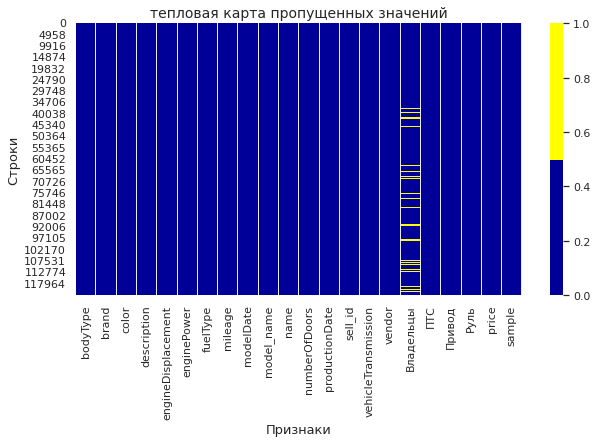

In [298]:
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
# строим тепловую карта пропущенных значений
# Увеличьте размер 
plt.figure(figsize=(10,5))
heat_map = sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))
heat_map.axes.set_title("тепловая карта пропущенных значений", fontsize=14)
heat_map.set_xlabel("Признаки", fontsize=13)
heat_map.set_ylabel("Строки", fontsize=13)

In [299]:
data.isnull().sum()

bodyType                  0
brand                     0
color                     0
description               0
engineDisplacement      158
enginePower               0
fuelType                  0
mileage                   0
modelDate                 0
model_name                0
name                      0
numberOfDoors             0
productionDate            0
sell_id                   0
vehicleTransmission       0
vendor                    0
Владельцы              9449
ПТС                       0
Привод                    0
Руль                      0
price                     0
sample                    0
dtype: int64

#### **Признак "engineDisplacement" и "Владельцы"** имеют пропуски, заполним их

In [300]:
# Владельцев заполним модой:
data['Владельцы'].fillna((data['Владельцы'].mode()[0]), inplace=True)

In [301]:
# посмотрим какому типу двигателя принадлежат пропуски
data[data['engineDisplacement'].isnull() == True]['fuelType'].unique()

array(['электро'], dtype=object)

In [302]:
#Значения мощности пустые для электродвигателей, заполняем пропуски 0.
data.engineDisplacement = data.engineDisplacement.fillna(0)
data.engineDisplacement.isnull().sum()

0

####  Добавим ***новый*** ***признак "model_age" и "production_age"*** (возраст модели и возраст машины)

In [303]:
# введем новые признаки возраст модели и возраст машины 
data['model_age'] = 2020 - data['modelDate'] 
data['production_age'] = 2020 - data['productionDate'] 

####Добавим ***новый признак "new"*** (новое авто) по отсутствию пробега

In [304]:
#добавим признак нового авто по отсутствию пробега
data['new'] = data['mileage'].apply(lambda x: 1 if x==0 else 0)

####Добавим ***новый признак "rarity"*** (раритет)

Text(0, 0.5, 'Возраст')

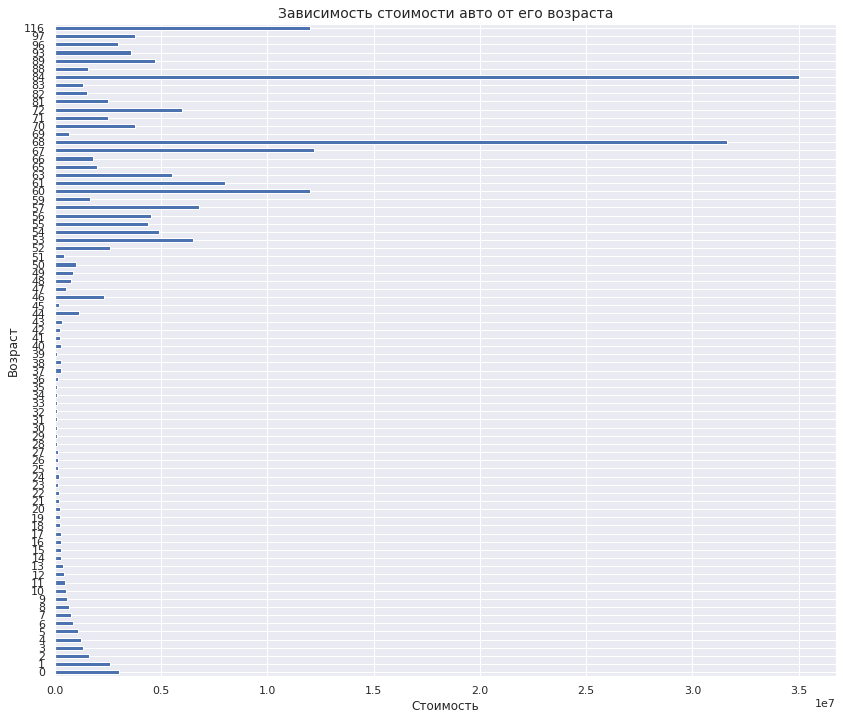

In [305]:
#Посмотрим зависимость стоимости от возраста на тренировочном датасете
plt.figure(figsize=(14,12))
plt.rcParams.update({'font.size': 8})
rarity_plt=data.query('sample==1').groupby('production_age').price.median().plot(kind='barh')
rarity_plt.axes.set_title("Зависимость стоимости авто от его возраста", fontsize=14)
rarity_plt.set_xlabel("Стоимость", fontsize=12)
rarity_plt.set_ylabel("Возраст", fontsize=12)

можно заметить снижение цены до 40-45 лет,
потом уже идет как рариретные авто - для них стоимость уже растет. 
Добавим новый признак.

In [306]:
# новый признак раритет
data['rarity'] = data['production_age'].apply(lambda x: 1 if x>40 else 0)

#### Добавим ***новый признак "transmission"***

In [307]:
data['name'][1]

'1.6 MT (110 л.с.)'

In [308]:
#признак содержит данные которые есть в других столбцах, но из него можно выбрать тип трансмиссии
data['name'] = data['name'].astype(str)
data['transmission'] = data['name'].str.extract('([A][T]|[M][T]|[A][M][T]|[C][V][T])', expand=False).str.strip()

In [309]:
data['transmission'].unique()

array(['AMT', 'MT', 'AT', 'CVT'], dtype=object)

Text(0, 0.5, 'Кол-во авто')

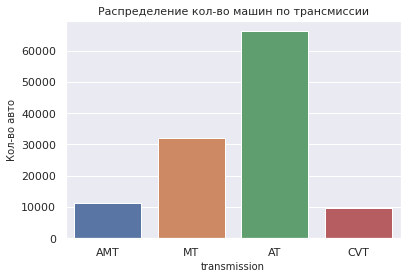

In [310]:
plt.figure(figsize=(6,4))
sns.countplot(x = data['transmission'], data = data)
plt.title('Распределение кол-во машин по трансмиссии', fontsize=11)
plt.xlabel("transmission", fontsize=10)
plt.ylabel("Кол-во авто", fontsize=10)

In [311]:
# теперь в признаке 'name' нет необходимости, удалим его!
data=data.drop('name',axis=1)

#### Добавим новый признак "cat_enginePower" (категория мощности двигателя)

In [312]:
data['enginePower'].min(), data['enginePower'].max(), len(data['enginePower'].unique())

(11.0, 717.0, 393)

In [313]:
# Разобьём признак enginePower на категории
def cat_engine_power(x):
    if x < 100: x = 1
    elif 99 < x < 150: x = 2
    elif 149 < x < 200: x = 3
    elif 199 < x < 250: x = 4
    elif 249 < x < 300: x = 5
    elif 299 < x < 350: x = 6
    elif 349 < x < 400: x = 7
    elif 399 < x < 450: x = 8
    elif 449 < x < 500: x = 9
    elif 499 < x < 550: x = 10
    elif 549 < x < 600: x = 11
    else: x = 12
    return x  
data['cat_enginePower'] = data['enginePower'].map(cat_engine_power)

Text(0, 0.5, 'Кол-во авто')

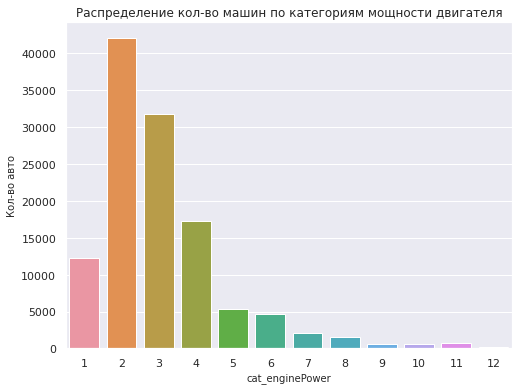

In [314]:
plt.figure(figsize=(8,6))
sns.countplot(x = data['cat_enginePower'], data = data)
plt.title('Распределение кол-во машин по категориям мощности двигателя', fontsize=12)
plt.xlabel("cat_enginePower", fontsize=10)
plt.ylabel("Кол-во авто", fontsize=10)

#### обозначим строковые и числовые признаки

In [315]:
# посмотрим на количество уникальных значений в каждом признаке:
data.nunique(dropna=False)

bodyType                  18
brand                     36
color                     16
description             6867
engineDisplacement        68
enginePower              393
fuelType                   5
mileage                24304
modelDate                 78
model_name              1104
numberOfDoors              5
productionDate            80
sell_id                34686
vehicleTransmission        4
vendor                     5
Владельцы                  3
ПТС                        2
Привод                     3
Руль                       2
price                   8030
sample                     2
model_age                 78
production_age            80
new                        2
rarity                     2
transmission               4
cat_enginePower           12
dtype: int64

In [316]:
int64_columns = [c for c in data.columns if (data[c].dtypes == 'int64')]
object_columns = [c for c in data.columns if data[c].dtypes == 'object']
float64_columns = [c for c in data.columns if data[c].dtypes == 'float64']
print('int64_columns = ',int64_columns)
print('object_columns = ',object_columns)
print('float64_columns = ',float64_columns)

int64_columns =  ['description', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate', 'sell_id', 'sample', 'model_age', 'production_age', 'new', 'rarity', 'cat_enginePower']
object_columns =  ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'transmission']
float64_columns =  ['engineDisplacement', 'enginePower', 'Владельцы', 'price']


In [317]:
# создадим списки признаков
# sell_id, price, sample не включаем в списки

target = ['price']  # целевая переменная 

# категориальные признаки 
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vehicleTransmission', 'vendor', 'Привод', 'transmission','ПТС', 'Руль']

# числовые признаки
num_cols = ['description', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate','model_age',
            'production_age','engineDisplacement', 'enginePower', 'Владельцы','cat_enginePower','new', 'rarity']      

# бинарные признаки
#bin_cols = ['ПТС', 'Руль', 'new', 'rarity']

In [318]:
#текстовые поля, которые возможно пригодятся
#txt_res_col = ['name', 'vehicleConfiguration']


#### ***Анализ целевой переменной (price)***

In [319]:
data.price[data['sample'] == 1].describe()

count    8.430300e+04
mean     1.208481e+06
std      1.889062e+06
min      1.600000e+04
25%      3.490000e+05
50%      6.200000e+05
75%      1.300000e+06
max      9.900000e+07
Name: price, dtype: float64

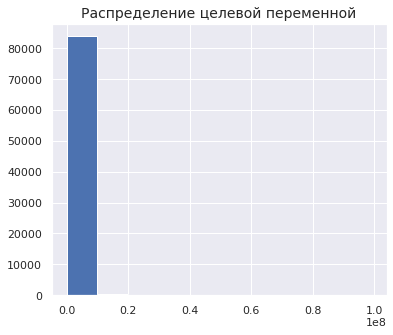

In [320]:
# посмотрим на распределение целевой переменной:
plt.figure(figsize=(6, 5))
data.query('sample == 1').price.hist();
plt.title("Распределение целевой переменной", fontdict={'fontsize': 14});
plt.show()

Text(0.5, 1.0, 'Распределение целевой переменной')

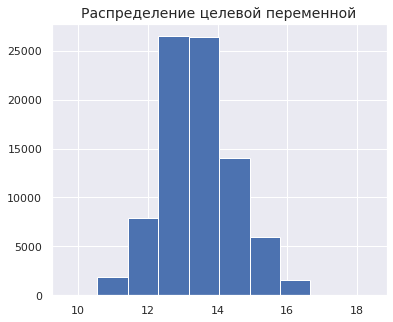

In [321]:
plt.figure(figsize=(6, 5))
np.log(data.query('sample == 1').price).hist()
plt.title('Распределение целевой переменной', fontdict={'fontsize': 14})

# добавили новый признак в датасет:
#data['price_log'] = np.log(data.price)

#### ***Числовые признаки***

распределение числовых признаков

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

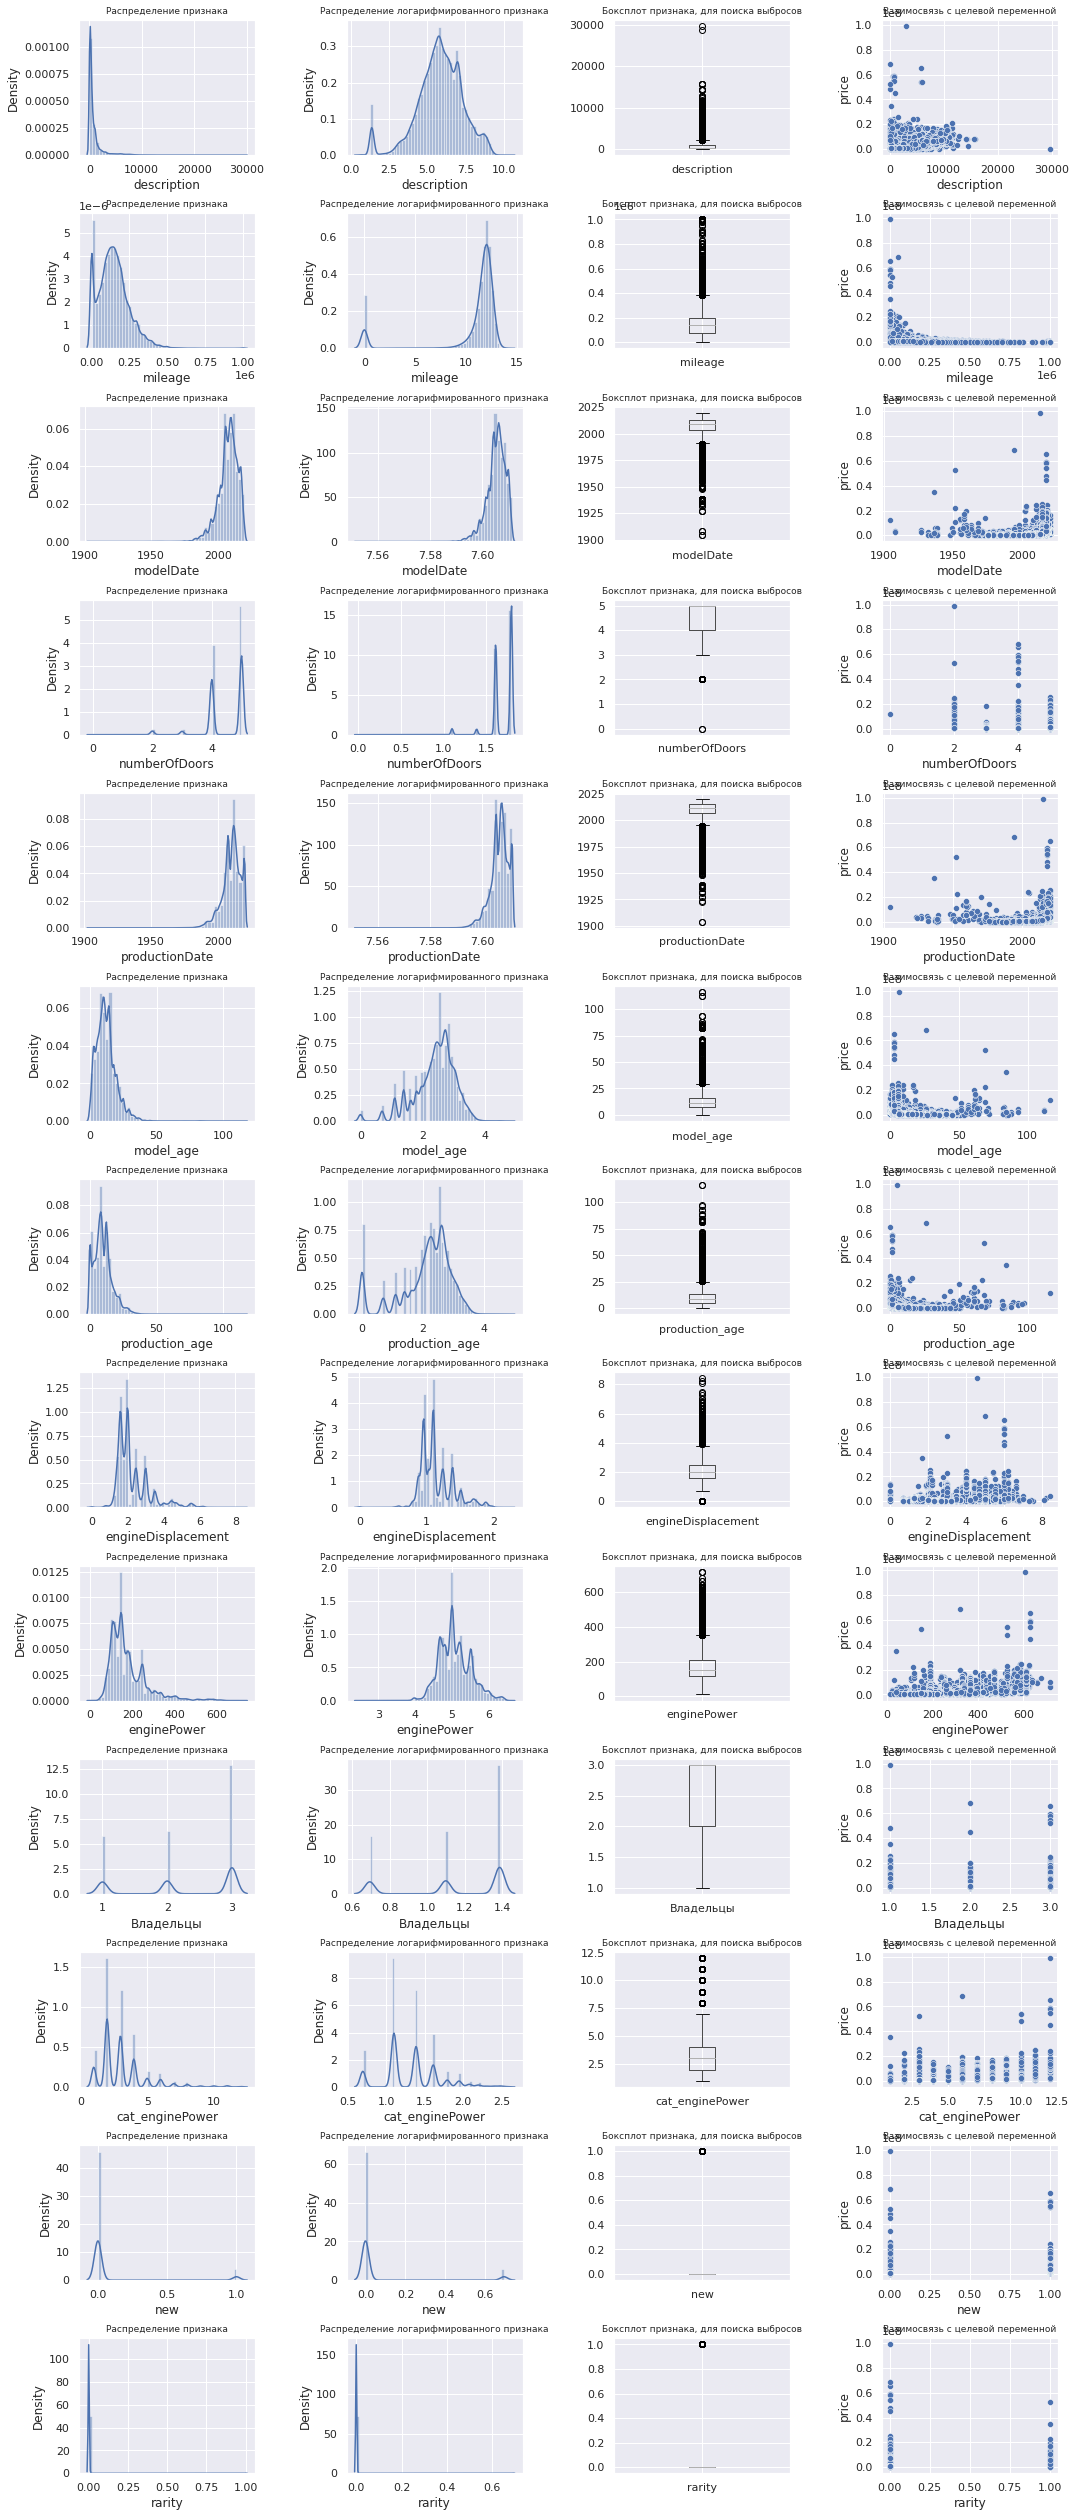

In [322]:
# Построим распределение числовых признаков

fig, axes = plt.subplots(13, 4, figsize=(15, 35))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0
for col in num_cols:
    sns.distplot(data[col], ax=axes[i]).set_title('Распределение признака',fontsize=9)
    i = i + 1
    sns.distplot(np.log(data[col]+1), ax=axes[i]).set_title('Распределение логарифмированного признака',fontsize=9)
    i = i + 1
    data[[col]].boxplot(ax=axes[i]).set_title('Боксплот признака, для поиска выбросов',fontsize=9)
    i=i+1
    sns.scatterplot(data=data[data['sample'] == 1],
                    x=col, y="price", ax=axes[i]).set_title('Взаимосвязь с целевой переменной',fontsize=9)
    i = i + 1
plt.tight_layout()


Выбросов не так много и они похожи на реальные данные. Например, раритетный автомобиль без дверей, который может стоить очень дорого. Самые большие выбросы присутствуют в целевой переменной. Но избавляться от них не будем.

In [323]:
#for i in num_cols:
 #   plt.figure(figsize=(2,2))
  #  sns.distplot(data[i])
   # plt.title('Распределение признака')
    #plt.show()    

влияние на целевой показатель численных переменных

numberOfDoors          1.583906
rarity                 2.095705
Владельцы              3.483981
engineDisplacement     4.918112
mileage                8.211257
cat_enginePower       10.279422
enginePower           11.339803
productionDate        13.988139
production_age        13.988139
modelDate             14.371312
model_age             14.371312
description           41.682970
new                   79.980428
dtype: float64

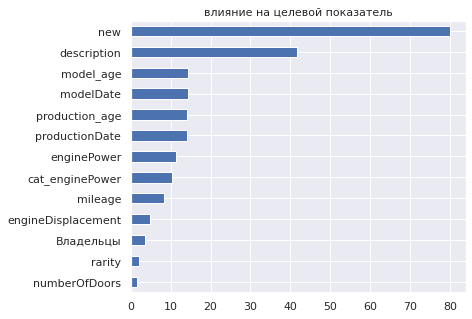

In [324]:
#Посмотрим влияние на целевой показатель численных переменных  
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols], data[data['sample'] == 1].price)[0], index = num_cols)
imp_num.sort_values(inplace = True)
plt.figure(figsize=(6,5))
imp_num.plot(kind = 'barh').set_title('влияние на целевой показатель',fontsize=11)
display(imp_num)

numberOfDoors          1.583906
rarity                 2.095705
Владельцы              3.483981
engineDisplacement     5.155322
cat_enginePower       10.279422
enginePower           11.339803
productionDate        13.988139
modelDate             14.371312
model_age             27.516776
production_age        35.348925
description           41.682970
mileage               72.610355
new                   79.980428
dtype: float64

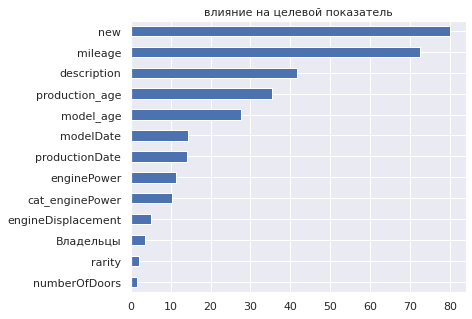

In [325]:
# Логарифмируем часть переменных
for i in ['mileage','model_age','production_age','engineDisplacement']:
    data[i] = data[i].apply(lambda x: np.log(float(x)+1))
#  и посмотрим влияние на целевой параметр числовых признаков с некоторыми прологарифмированными признаками
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols], data[data['sample'] == 1].price)[0], index = num_cols)
imp_num.sort_values(inplace = True)
plt.figure(figsize=(6,5))
imp_num.plot(kind = 'barh').set_title('влияние на целевой показатель',fontsize=11)
display(imp_num)

 корреляция числовых признаков

Text(0.5, 1.0, 'Треугольная тепловая карта корреляции числовых признаков и целевой переменной')

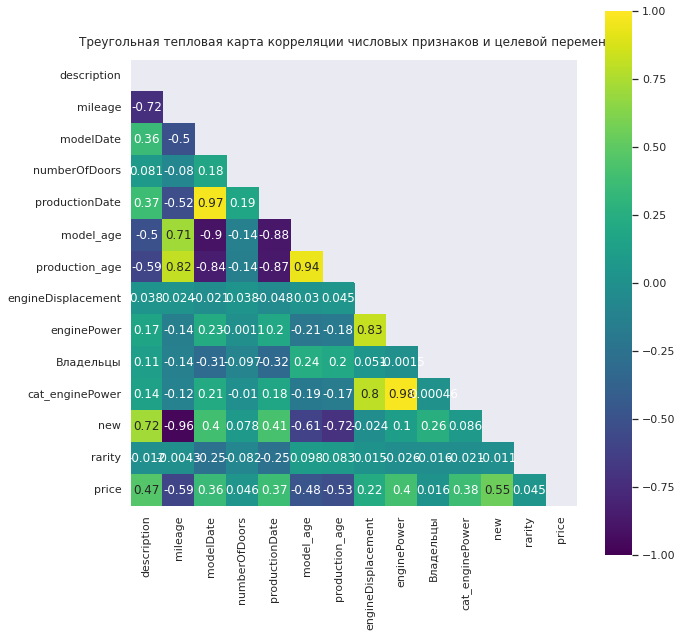

In [326]:
# построим корреляцию числовых признаков
sns.set(rc = {'figure.figsize':(10,10)})
upp_mat = np.triu(data[num_cols + target].corr())
heatmap = sns.heatmap(data[num_cols + target].corr(),vmin = -1, vmax = +1, annot = True, square=True, cmap= 'viridis',mask = upp_mat)
heatmap.set_title('Треугольная тепловая карта корреляции числовых признаков и целевой переменной', fontdict={'fontsize':12}, pad=14)

* Заметим, что после логарифмирования признаков , влияние на целевой параметр усилилось!
* видно, что самое большое влияние оказывает созданный признак "new"(новый 
авто или нет), самое незначительное влияние имеет признак "numberOfDoors"(кол-во дверей).

* признаки "modelDate" и "model_age", а так же признаки "production_age" и "productionDate" имеют высокую корреляцию между собой, что логично. ( В идеале оставим только признак "model_age" возраст модели, так как имеет большее влияние, чем "production_age" возраст авто, а сильная корреляция может отрицательно сказаться, (но в ходе тестов, было выявлено, что удаление одного из признаков снижает значение целевей метрики)).

* Средняя корреляция наблюдается между "mileage" и p"roductionDate", "mileage" и "Владельцы". Данные взаимосвязи вполне естественны. Чем больше возраст авто, тем больше у него пробег и количество владельцев.

* признаки мощность двигателя, новый признак категория мощности двигателя и обьем двигателя коррелируют между собой. (пока удалим признак мощности двигателя, но если результаты метрики с ним будут лучше, то не будем удалять)

In [327]:
#data = data.drop(["modelDate"],axis=1)
#data = data.drop(["production_age"],axis=1)
data = data.drop(['productionDate'],axis=1)
#data = data.drop(['enginePower'],axis=1)
#num_cols.remove('modelDate')
#num_cols.remove("production_age")
num_cols.remove('productionDate')
#num_cols.remove('enginePower')

проверим числовые признаки на выбросы

#### Категориальные признаки

In [328]:
# посмотрим на количество уникальных значений в каждом категориальном признаке:
data[cat_cols].nunique(dropna=False)

bodyType                 18
brand                    36
color                    16
fuelType                  5
model_name             1104
vehicleTransmission       4
vendor                    5
Привод                    3
transmission              4
ПТС                       2
Руль                      2
dtype: int64

видно, что признак 'model_name' имеет очень большой спектр значений(1104)

"bodyType" (18), "brand"(36) и "color"(16) - не много значений, но и не мало.

Остальные 7 категориальных признаков имеют небольшие спектры значений.

#####**Encoding**

Frequency Encoding

In [329]:
# Используем Frequency Encoding для признаков с высокой спектром значений.
#Frequency Encoding list
cat_big_cols= ['model_name', 'brand', 'color', 'bodyType']

#Функция Frequency Encoding
def freqenc_encoding_cat_big_cols(cols):
    fe = data.groupby(cols).size()/len(data)*100
    data.loc[:, cols] = data[cols].map(fe)
    
#Encoding    
for i in cat_big_cols:
    freqenc_encoding_cat_big_cols(i)

Label Encoding

In [330]:
# Преобразуем все значения категориальных признаков в числа:
cat_LE_cols = ['fuelType','vehicleTransmission','vendor','Привод','transmission', 'ПТС', 'Руль']
label_encoder = LabelEncoder()
for i in cat_LE_cols:
    label_encoder.fit(data[i])
    data[i] = label_encoder.transform(data[i])

In [331]:
# Кодируем категориальные признаки
#for col in cat_LE_cols:
    #data[col] = data[col].astype('category').cat.codes

In [332]:
data.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,price,sample,model_age,production_age,new,rarity,transmission,cat_enginePower
0,4.574411,4.557602,9.799307,1001,0.788457,105.0,0,11.211834,2013,2.361583,5,1100575026,2,2,3.0,1,1,0,0.0,0,2.079442,1.945910,0,0,0,2
1,4.574411,4.557602,29.013850,2609,0.955511,110.0,0,11.011456,2017,2.361583,5,1100549428,1,2,1.0,1,1,0,0.0,0,1.386294,1.386294,0,0,3,2
2,4.574411,4.557602,11.926413,1001,1.029619,152.0,0,11.385103,2013,0.402562,5,1100658222,2,2,1.0,1,1,0,0.0,0,2.079442,1.945910,0,0,0,3
3,4.574411,4.557602,4.065956,1676,0.955511,110.0,0,11.461643,2013,2.361583,5,1100937408,0,2,1.0,1,1,0,0.0,0,2.079442,1.945910,0,0,1,2
4,4.574411,4.557602,17.405116,2365,1.029619,152.0,0,10.977414,2008,2.361583,5,1101037972,0,2,1.0,1,1,0,0.0,0,2.564949,2.197225,0,0,1,3


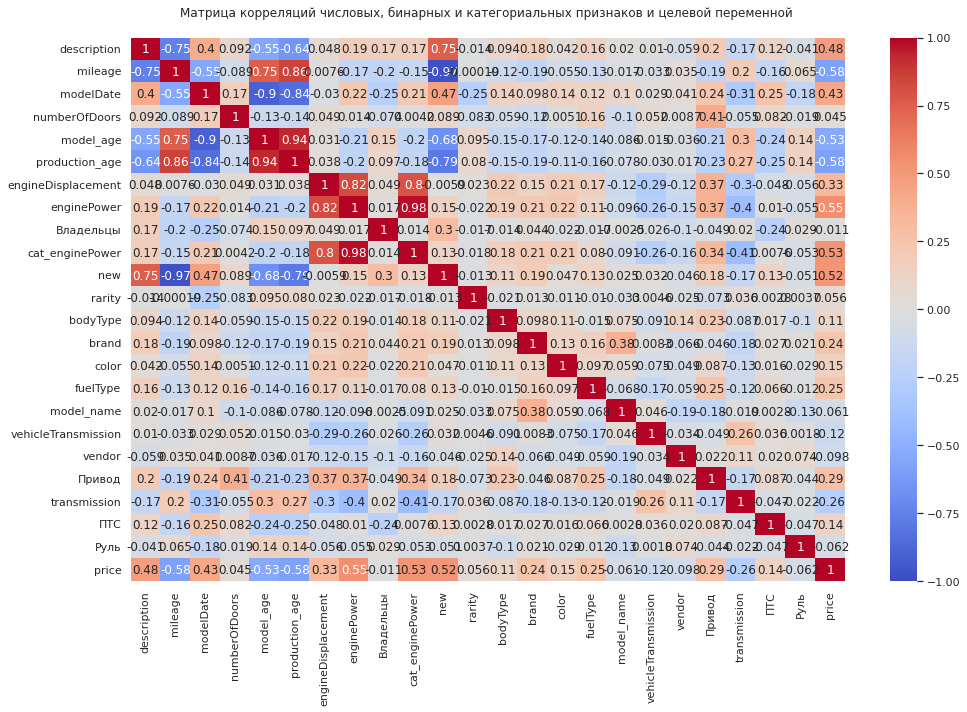

In [333]:
# Построим матрицу корреляций для числовых, бинарных и категориальных признаков и целевой переменной
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(data[data['sample'] == 1][num_cols+cat_cols + target].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Матрица корреляций числовых, бинарных и категориальных признаков и целевой переменной \n')
plt.show()

Корреляция признаков присутствует, но пока не будем ничего удалять. Возможно нам все понадобится.

Руль                    0.382361
ПТС                     0.782649
vendor                  0.955726
bodyType                1.540054
model_name              1.543591
numberOfDoors           1.583906
color                   1.685542
rarity                  2.095705
vehicleTransmission     2.437157
brand                   2.989947
Привод                  3.322302
Владельцы               3.483981
fuelType                4.174474
transmission            4.333548
engineDisplacement      5.155322
cat_enginePower        10.279422
enginePower            11.339803
modelDate              14.371312
model_age              27.516776
production_age         35.348925
description            41.682970
mileage                72.610355
new                    79.980428
dtype: float64

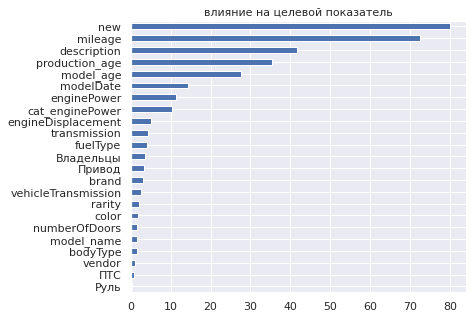

In [334]:
cat_num_cols = num_cols+cat_cols
# посмотрим влияние на целевой параметр всех признаков (с некоторыми прологарифмированными признаками)
imp_num = pd.Series(f_classif(data[data['sample'] == 1][cat_num_cols], data[data['sample'] == 1].price)[0], index = cat_num_cols)
imp_num.sort_values(inplace = True)
plt.figure(figsize=(6,5))
imp_num.plot(kind = 'barh').set_title('влияние на целевой показатель',fontsize=11)
display(imp_num)

Стандартизация числовых признаков

In [335]:
# Стандартизация числовых переменных
cols_to_scale = list(set(data.columns) & set(num_cols))
data[cols_to_scale] = StandardScaler().fit_transform(data[cols_to_scale].values)

####Выделяем тестовую и тренировочную части, целевую часть

#####Оценка моделей с Lazypredict

In [336]:
data_0 = data.copy()
X_sub = data_0.query('sample == 0').drop(['sample', 'price'], axis=1)
#Разметка датасета, вариант 1
data_0 = data_0[data_0['sample']==1]
X = data_0.drop(['price','sample','sell_id'], axis=1)
# В качестве y указываем обычную цену
y = data_0['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True, random_state=RANDOM_SEED)

In [337]:
# Lazypredict для оценки эффективности различных моделей
#reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#models, predictions = reg.fit(X_train, X_test, y_train, y_test)
#models

##### вариант1

In [338]:
data_1 = data.copy()

In [339]:
X_sub = data_1.query('sample == 0').drop(['sample', 'price'], axis=1)
#Разметка датасета, вариант 1
data_1 = data_1[data_1['sample']==1]
X = data_1.drop(['price','sample','sell_id'], axis=1)
# В качестве y указываем обычную цену
y = data_1['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True, random_state=RANDOM_SEED)

In [340]:
#Функция для выбора моделей и первого обучения без параметров
def overview_model (data):
      
    data_test = data[data['price']==1]
    X_sub = data.drop(['price'], axis=1)

    #DecisionTreeRegressor 
    DTG = DecisionTreeRegressor()
    DTG.fit(X_train, y_train)
    y_pred = DTG.predict(X_test)
    predict = y_pred
    #DecisionTreeRegressor MAPE
    print(f"Точность Decision Tree Regressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
    #XGBRegressor
    xgbr = xgb.XGBRegressor() 
    xgbr.fit(X_train, y_train)
    y_pred = xgbr.predict(X_test)
    predict = y_pred
    #XGBRegressor MAPE
    print(f"Точность XGBRegressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
    #LinearRegression
    LinReg = LinearRegression() 
    LinReg.fit(X_train, y_train)
    y_pred = LinReg.predict(X_test)
    predict = y_pred
    #LinearRegression MAPE
    print(f"Точность Linear Regression по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
    #Ridge
    Rg = Ridge() 
    Rg.fit(X_train, y_train)
    y_pred = Rg.predict(X_test)
    predict = y_pred
    #Ridge MAPE
    print(f"Точность Ridge по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
    #ElasticNet
    ElNet = ElasticNet() 
    ElNet.fit(X_train, y_train)
    y_pred = ElNet.predict(X_test)
    predict = y_pred
    #ElasticNet MAPE
    print(f"Точность Elastic Net по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
    #RandomForestRegressor
    RFG = RandomForestRegressor() 
    RFG.fit(X_train, y_train)
    y_pred = RFG.predict(X_test)
    predict = y_pred
    #RandomForestRegressor MAPE
    print(f"Точность Random Forest Regressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")    
    
    #AdaBoostRegressor
    ABR = AdaBoostRegressor() 
    ABR.fit(X_train, y_train)
    y_pred = ABR.predict(X_test)
    predict = y_pred
    #AdaBoostRegressor MAPE
    print(f"Точность Ada Boost Regressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
    #ExtraTreesRegressor
    ETR = ExtraTreesRegressor()
    ETR.fit(X_train, y_train)
    y_pred = ETR.predict(X_test)
    predict = y_pred
    #ExtraTreesRegressor MAPE
    print(f"Точность Extra Trees Regressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%") 

In [341]:
#Обучение без параметров, к варианту 1, определение лучшей модели
#overview_model (data_1)

* Точность Decision Tree Regressor по метрике MAPE: 20.65%
* Точность XGBRegressor по метрике MAPE: 27.36%
* Точность Linear Regression по метрике MAPE: 85.21%
* Точность Ridge по метрике MAPE: 85.20%
* Точность Elastic Net по метрике MAPE: 78.88%
* Точность Random Forest Regressor по метрике MAPE: 15.22%
* Точность Ada Boost Regressor по метрике MAPE: 265.02%
* Точность Extra Trees Regressor по метрике MAPE: 15.00%

#####вариант2

In [342]:
data_2 = data.copy()

In [343]:
# Разметка датасета, вариант 2
# Разделяем обратно train и test
data_2= data_2[data_2['sample'] == 1]

X_sub = data_2.query('sample == 0').drop(['sample', 'price'], axis=1)

data_2 = data_2[data_2['sample']==1]
X = data_2.drop(['price','sample','sell_id'], axis=1)
# В качестве y указываем обычную цену
y = np.log(data_2['price'])

# Делим train для обучения и проверки моделей
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [344]:
#Функция для выбора моделей при логарифмированной целевой переменной
def overview_model_2 (data):    
     
    data_test = data[data['price']==1]
    X_sub = data.drop(['price'], axis=1)

    #DecisionTreeRegressor
    DTG = DecisionTreeRegressor()
    DTG.fit(X_train, y_train)
    y_pred = np.exp(DTG.predict(X_test))
    predict = y_pred
    #DecisionTreeRegressor MAPE
    print(f"Точность Decision Tree Regressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
    #XGBRegressor
    xgbr = xgb.XGBRegressor() 
    xgbr.fit(X_train, y_train)
    y_pred = np.exp(xgbr.predict(X_test))
    predict = y_pred
    #XGBRegressor MAPE
    print(f"Точность XGBRegressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
    #LinearRegression
    LinReg = LinearRegression() 
    LinReg.fit(X_train, y_train)
    y_pred = np.exp(LinReg.predict(X_test))
    predict = y_pred
    #LinearRegression MAPE
    print(f"Точность Linear Regression по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
    #Ridge
    Rg = Ridge() 
    Rg.fit(X_train, y_train)
    y_pred = np.exp(Rg.predict(X_test))
    predict = y_pred
    #Ridge MAPE
    print(f"Точность Ridge по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
    #ElasticNet
    ElNet = ElasticNet() 
    ElNet.fit(X_train, y_train)
    y_pred = np.exp(ElNet.predict(X_test))
    predict = y_pred
    #ElasticNet MAPE
    print(f"Точность Elastic Net по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
    #RandomForestRegressor
    RFG = RandomForestRegressor() 
    RFG.fit(X_train, y_train)
    y_pred = np.exp(RFG.predict(X_test))
    predict = y_pred
    #RandomForestRegressor MAPE
    print(f"Точность Random Forest Regressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")    
    
    #AdaBoostRegressor
    ABR = AdaBoostRegressor() 
    ABR.fit(X_train, y_train)
    y_pred = np.exp(ABR.predict(X_test))
    predict = y_pred
    #AdaBoostRegressor MAPE
    print(f"Точность Ada Boost Regressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
    #ExtraTreesRegressor
    ETR = ExtraTreesRegressor()
    ETR.fit(X_train, y_train)
    y_pred = np.exp(ETR.predict(X_test))
    predict = y_pred
    #ExtraTreesRegressor MAPE
    print(f"Точность Extra Trees Regressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%") 

In [345]:
#Обучение без параметров, к варианту 2, определение лучшей модели
#overview_model_2(data_2)

* Точность Decision Tree Regressor по метрике MAPE: 8243536.42%
* Точность XGBRegressor по метрике MAPE: 7915568.17%
* Точность Linear Regression по метрике MAPE: 7869605.98%
* Точность Ridge по метрике MAPE: 7869505.30%
* Точность Elastic Net по метрике MAPE: 5249780.84%
* Точность Random Forest Regressor по метрике MAPE: 8113671.43%
* Точность Ada Boost Regressor по метрике MAPE: 6423755.56%
* Точность Extra Trees Regressor по метрике MAPE: 8128336.24%

##### вариант3

In [346]:
data_3 = data.copy()

In [347]:
X_sub = data_3.query('sample == 0').drop(['sample', 'price'], axis=1)
#Разметка датасета, вариант 3
data_3 = data_3[data_3['sample']==1]
X = data_3.drop(['price','sample'], axis=1)
# В качестве y указываем обычную цену
y = data_3['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True, random_state=RANDOM_SEED)

#####**RandomForestRegressor**

In [348]:
rfr = RandomForestRegressor(random_state = RANDOM_SEED)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)
print(f"Точность модели по метрике MAPE c неизмененным таргетом: {(mape(y_test, rfr_pred))*100:0.2f}%")

# с логарифмированием целевой переменной
rfr_log = RandomForestRegressor(random_state = RANDOM_SEED)
rfr_log.fit(X_train, np.log(y_train))
rfr_log_pred = np.exp(rfr_log.predict(X_test))
print(f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, rfr_log_pred))*100:0.2f}%")

Точность модели по метрике MAPE c неизмененным таргетом: 15.35%
Точность модели по метрике MAPE с логтаргетом: 13.21%


Логарифмирование целевой переменной улучшает показатель MAPE, поэтому будем использовать только логтаргет.

In [349]:
# это ооочень долго!!
#Подбор гиперпараметров для модели

#random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=4)],
#               'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False]}

#rfr = RandomForestRegressor(random_state=RANDOM_SEED)
#rf_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid,
#                               n_iter=100, cv=3, verbose=10, random_state=RANDOM_SEED, n_jobs=-1)

#rf_random.fit(X_train, np.log(y_train.astype(np.int64)))
#rf_random.best_params_

In [350]:
# Обучим модель на лучших гиперпараметрах

best_rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=200, min_samples_split=2, min_samples_leaf=1, 
                                 max_features='log2', max_depth=None, bootstrap=True)
best_rfr.fit(X_train, np.log(y_train.astype(np.int64)))
best_rfr_pred = np.exp(best_rfr.predict(X_test))
print(f"Точность модели по метрике MAPE с логтаргетом и с параметрами: {(mape(y_test, best_rfr_pred))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом и с параметрами: 12.95%


#####**XGBRegressor**

In [351]:
xgbr = xgb.XGBRegressor(random_state = RANDOM_SEED) 
xgbr.fit(X_train, y_train)
xgbr_pred = (xgbr.predict(X_test))
print(f"Точность модели по метрике MAPE c неизмененным таргетом: {(mape(y_test, xgbr_pred))*100:0.2f}%")

xgbr_log = xgb.XGBRegressor(random_state = RANDOM_SEED) 
xgbr_log.fit(X_train, np.log(y_train))
xgbr_log_pred = np.exp(xgbr_log.predict(X_test))
print(f"Точность модели по метрике MAPE c логтаргетом: {(mape(y_test, xgbr_log_pred))*100:0.2f}%")

[08:55:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Точность модели по метрике MAPE c неизмененным таргетом: 27.36%
[08:55:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Точность модели по метрике MAPE c логтаргетом: 19.23%


In [352]:
# Параметры подбирались вручную
xgbr = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.5,learning_rate=0.05,
                        max_depth=12,alpha=1,n_estimators=1000, random_state=RANDOM_SEED, n_jobs=-1)

xgbr.fit(X_train, np.log(y_train))
predict_xgbr = np.exp(xgbr.predict(X_test))
print(f"Точность модели по метрике MAPE с логтаргетом и параметрами: {(mape(y_test, predict_xgbr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом и параметрами: 12.28%


#####**Extra Tree Regressor**

In [353]:
# Запустим модель со стандартными параметрами
extr = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
extr.fit(X_train, (y_train))
extr_pred = (extr.predict(X_test))
print(f"Точность модели по метрике MAPE c неизмененным таргетом: {(mape(y_test, extr_pred))*100:0.2f}%")

extr_log = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
extr_log.fit(X_train, np.log(y_train))
extr_log_pred = np.exp(extr_log.predict(X_test))
print(f"Точность модели по метрике MAPE c логтаргетом: {(mape(y_test, extr_log_pred))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Точность модели по метрике MAPE c неизмененным таргетом: 15.07%


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s


Точность модели по метрике MAPE c логтаргетом: 13.36%


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.0s finished


In [354]:
# подбор гиперпараметров для модели

#random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4],
#             'bootstrap': [True, False]}

#etr = ExtraTreesRegressor(random_state=RANDOM_SEED)
#etr_random = RandomizedSearchCV(estimator=etr, param_distributions=random_grid, n_iter=100, cv=3, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)
#rf_random.fit(X_train, y_train)
#etr_random.fit(X_train, np.log(y_train))
#etr_random.best_params_

In [355]:
# Запустим модель с подобранными параметрами:
param_extr = ExtraTreesRegressor(n_estimators = 100,min_samples_split= 2,min_samples_leaf= 1,max_features= 'auto',
                               max_depth= 15, bootstrap= False, random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
param_extr.fit(X_train, np.log(y_train))
param_extr_pred = np.exp(param_extr.predict(X_test))
print(
    f"Точность модели по метрике MAPE c логтаргетом и параметрами: {(mape(y_test, param_extr_pred))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s


Точность модели по метрике MAPE c логтаргетом и параметрами: 13.65%


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished


Поиск гиперпараметров не улучшил результат, а даже ухудшил. а время на вычисления оооооочень много затрачено

#####**LGBMRegressor**

In [356]:
lgbm = LGBMRegressor(random_state=RANDOM_SEED)
lgbm.fit(X_train, (y_train))
lgbm_pred = (lgbm.predict(X_test))
print(f"Точность модели по метрике MAPE с неизмененным таргетом: {(mape(y_test, lgbm_pred))*100:0.2f}%")

lgbm_log = LGBMRegressor(random_state=RANDOM_SEED)
lgbm_log.fit(X_train, np.log(y_train))
lgbm_log_pred = np.exp(lgbm_log.predict(X_test))
print(f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, lgbm_log_pred))*100:0.2f}%")

Точность модели по метрике MAPE с неизмененным таргетом: 21.34%
Точность модели по метрике MAPE с логтаргетом: 15.44%


In [357]:
# подбор гиперпараметров
lgbm = LGBMRegressor(random_state=RANDOM_SEED, objective='regression', num_iterations=1000, n_estimators=100, learning_rate=0.01,
                     num_leaves=1000, min_child_samples=3,  colsample_bytree=0.5)
lgbm.fit(X_train, np.log(y_train))
predict_lgbm = np.exp(lgbm.predict(X_test))
print(f"Точность модели по метрике MAPE с логтаргетом и гиперпараметрами: {(mape(y_test, predict_lgbm))*100:0.2f}%")

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Точность модели по метрике MAPE с логтаргетом и гиперпараметрами: 12.31%


#####**Стекинг:LGBMRegressor, Xgboosting +LinearRegression**

In [358]:
estimators = [('lgbm', LGBMRegressor(random_state=RANDOM_SEED, objective='regression', num_iterations=1000, 
                                     n_estimators=100, learning_rate=0.01, num_leaves=1000, min_child_samples=3,  colsample_bytree=0.5)),
              ('xgb_reg', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05,
                                           max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000))]
#Попробуем в качестве мета-алгоритма LinearRegression
stec_linreg = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# оцениваем точность
stec_linreg.fit(X_train, np.log(y_train))
stec_linreg_pred = np.exp(stec_linreg.predict(X_test))
print(f"Точность модели по метрике MAPE c логтаргетом: {(mape(y_test, stec_linreg_pred))*100:0.2f}%")

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n

Точность модели по метрике MAPE c логтаргетом: 12.21%


#####**GradientBoostingRegressor**

In [359]:
#Пробуем градиентный бустинг с подобранными гиперпараметрами
GBR2 = GradientBoostingRegressor(random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=1250, max_depth=10)
GBR2.fit(X_train, np.log(y_train))

predict_test = np.exp(GBR2.predict(X_test))
#predict_submission = np.exp(GBR2.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.01%


#####Стек оценок с окончательным регрессором.(RandomForestRegressor)

In [360]:

estimators = [('lr', RidgeCV()),('svr', LinearSVR(random_state=42))]
reg = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=10, random_state=42))
reg.fit(X_train, np.log(y_train))
predict_test = np.exp(reg.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Точность модели по метрике MAPE: 31.81%


#####Стекинг: Xgboosting, ExtraTreesRegressor+LinearRegression

In [361]:
estimators = [('etr',ExtraTreesRegressor()),
              ('xgb_reg',xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000))]

st_boos_ensemble = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

# оцениваем точность
st_boos_ensemble.fit(X_train, np.log(y_train))
predict_e = np.exp(st_boos_ensemble.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

Точность модели по метрике MAPE: 12.29%


####**Submission**

Стекинг:LGBMRegressor, Xgboosting +LinearRegression дал лучший результат, его и будем использовать на тесте.

In [362]:
sample_submission.sample(4)

,sell_id,price
34367,1101363459,0
32286,1101343567,0
4342,1092515098,0
11741,1101248810,0


In [363]:
X_sub.head(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,model_age,production_age,new,rarity,transmission,cat_enginePower
0,4.574411,4.557602,9.799307,0.095272,-1.457620,-0.823316,0,0.125114,0.704948,2.361583,0.766449,1100575026,2,2,0.878281,1,1,0,-0.505836,-0.211468,-0.293703,-0.036579,0,-0.610278
1,4.574411,4.557602,29.013850,1.221603,-0.783579,-0.765120,0,0.064376,1.248166,2.361583,0.766449,1100549428,1,2,-1.568825,1,1,0,-1.583039,-0.874302,-0.293703,-0.036579,3,-0.610278
2,4.574411,4.557602,11.926413,0.095272,-0.484564,-0.276270,0,0.177634,0.704948,0.402562,0.766449,1100658222,2,2,-1.568825,1,1,0,-0.505836,-0.211468,-0.293703,-0.036579,0,-0.028565


In [365]:
predict_submission = np.exp(stec_linreg.predict(X_sub))
sample_submission['price_pred'] = pd.Series(predict_submission)
sample_submission.to_csv(path+'/submission_end.csv', index=False)
sample_submission.head(10)

,sell_id,price,price_pred
0,1100575026,0,5.923592e+05
1,1100549428,0,9.163808e+05
2,1100658222,0,8.289703e+05
3,1100937408,0,7.377781e+05
4,1101037972,0,6.825571e+05
5,1100912634,0,7.426170e+05
6,1101228730,0,6.218009e+05
7,1100165896,0,3.833540e+05
8,1100768262,0,1.716787e+06
9,1101218501,0,7.857039e+05


Полученный результат довольно неплохой, так как использованны базовые данные.

Очень медленно обрабатываются модели, особенно стекинг. Еще дольше идет поиск параметров. 

Расмотрено 10 моделей: некоторые показывали совсем плохой результат, а те которые показывали лучше, были проверены на логорифмированной целевой переменной, что на всех моделях улучшило результат. А вот подбор параметров не на всех моделях дал улучшение.



Для улучшения результата необходимо более тщательно обрабатывать каждый признак и использовать разные методы кодирования категориальных признаков. 


